# Disease_Similarity_Benchmark

## Load Data

In [1]:
# imports

import logging, sys, os
from tqdm import tqdm
import numpy as np, pandas as pd
from tqdm.contrib.concurrent import process_map
import pickle

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)
mesh_tree_terms_path = os.path.join("..", "data", "DiSignAtlas", "mesh_tree_terms.pkl")
mesh_ids_path = os.path.join("..", "data", "DiSignAtlas", "mesh_tree_terms.pkl")


# functions
def get_processed_ids():
    """Get processed ids
    Returns:
        list: list of processed ids
    """
    data_path = os.path.join("..", "data", "DiSignAtlas", "dsa_diff_download.processed")
    return [f.split("_")[0] for f in os.listdir(data_path)]


# Load the all genes per (human) signature


def get_signatures(dsaid, remove_duplicates=True):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..",
        "data",
        "DiSignAtlas",
        "dsa_diff_download.processed",
        f"{dsaid}_alldiff.txt",
    )

    if os.path.exists(data_path):
        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["GeneID"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["GeneID"].tolist()
        p_values = df_cleaned["PValue"].tolist()
        adj_p_values = df_cleaned["AdjPValue"].tolist()
        log2fc = df_cleaned["Log2FC"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc
    else:
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download.processed",
            f"{dsaid}_whole_diff_regulation.csv",
        )

        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["geneid"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["geneid"].tolist()
        p_values = df_cleaned["pvalue"].tolist()
        adj_p_values = df_cleaned["adjpvalue"].tolist()
        log2fc = df_cleaned["log2fc"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc


# get all entrez protein-coding human ids
def get_human_entrez_protein_coding_ids():
    """Get Human Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID", "type_of_gene"])
    df_human = df[(df["#tax_id"] == 9606) & (df["type_of_gene"] == "protein-coding")]
    logging.info(f"Nº of Human protein coding genes: {len(df_human)}")
    return df_human["GeneID"].to_list()


# load data

processed_ids = get_processed_ids()
logging.info(f"Nº of processed ids: {len(processed_ids)}")

df_data_info = pd.read_csv(data_info_path)

df_data_info_processed = df_data_info.copy()

df_data_info_processed = df_data_info_processed[
    df_data_info_processed["dsaid"].isin(processed_ids)
]

logging.info(f"Nº of processed ids in df_data_info: {len(df_data_info_processed)}")

df_data_info_processed_filtered = df_data_info_processed[
    (df_data_info_processed["organism"] == "Homo sapiens")
    & (
        (df_data_info_processed["library_strategy"] == "Microarray")
        | (df_data_info_processed["library_strategy"] == "RNA-Seq")
    )
]
logging.info(
    f"Nº of Filtered by library (filter out single cell): {df_data_info_processed_filtered.shape}"
)

2024-04-26 20:13:58,319 - INFO - Nº of processed ids: 7191
2024-04-26 20:13:58,435 - INFO - Nº of processed ids in df_data_info: 7191
2024-04-26 20:13:58,438 - INFO - Nº of Filtered by library (filter out single cell): (7001, 12)


In [2]:
logging.info(f"Loading file {mesh_tree_terms_path}")
with open(mesh_tree_terms_path, "rb") as f:
    data = pickle.load(f)
    mesh_tree_terms = data.get("mesh_tree_terms")
    mesh_dsaids = data.get("dsaids")
    mesh_ids = data.get("mesh_ids")
    dsaids_2_mesh_tree_terms = {k: v for k, v in zip(mesh_dsaids, mesh_tree_terms)}
    dsaids_2_mesh_ids = {k: v for k, v in zip(mesh_dsaids, mesh_ids)}

dsaids_with_mesh = [k for k, v in dsaids_2_mesh_tree_terms.items() if len(v) > 0]
logging.info(f"Nº of dsaids with mesh {len(dsaids_with_mesh)}")

2024-04-26 20:13:58,442 - INFO - Loading file ../data/DiSignAtlas/mesh_tree_terms.pkl
2024-04-26 20:13:58,451 - INFO - Nº of dsaids with mesh 7790


In [3]:
# get all entrez protein-coding human ids
human_entrez_protein_coding_ids = get_human_entrez_protein_coding_ids()

2024-04-26 20:15:22,779 - INFO - Nº of Human protein coding genes: 20607


In [4]:
thr_counts = 5
disease_2_counts = dict(df_data_info_processed_filtered["disease"].value_counts())

diseases_high_counts = [k for k, v in disease_2_counts.items() if v >= thr_counts]

logging.info(
    f"Nº of Diseases for Benchmark {len(diseases_high_counts)} / {len(disease_2_counts)}"
)

2024-04-26 20:15:22,870 - INFO - Nº of Diseases for Benchmark 276 / 1428


In [5]:
all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

disease_2_dsaids = dict()
for k, v in tqdm(zip(all_diseases, all_dsaids)):
    if k not in disease_2_dsaids.keys():
        disease_2_dsaids[k] = list()
    disease_2_dsaids[k].append(v)

7001it [00:00, 2848416.17it/s]


In [6]:
import pickle

path_pkl = os.path.join("..", "data", "DiSignAtlas", "signatures.pkl")

human_dsaids_processed = df_data_info_processed_filtered["dsaid"].to_list()
human_library_processed = df_data_info_processed_filtered["library_strategy"].to_list()

if not os.path.exists(path_pkl):

    signatures = process_map(
        get_signatures,
        human_dsaids_processed,
        max_workers=8,
        chunksize=10,
    )
    pickle.dump(signatures, open(path_pkl, "wb"))
    logging.info(f"Signatures saved {path_pkl}")

else:
    logging.info(f"Loading signatures from file {path_pkl}")
    signatures = pickle.load(open(path_pkl, "rb"))

2024-04-26 20:15:22,885 - INFO - Loading signatures from file ../data/DiSignAtlas/signatures.pkl


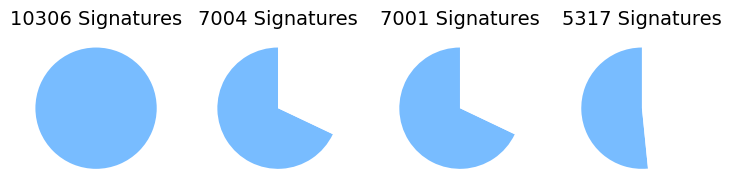

In [7]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = df_data_info[
    (df_data_info["organism"] == "Homo sapiens")
    & (
        (df_data_info["library_strategy"] == "RNA-Seq")
        | (df_data_info["library_strategy"] == "Microarray")
    )
].shape[0]
n_step_2 = df_data_info_processed_filtered.shape[0]
n_step_3 = len(
    set(dsaids_with_mesh) & set(df_data_info_processed_filtered["dsaid"].to_list())
)

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]
sizes_step_3 = [n_step_3, n_step_0 - n_step_3]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 4, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures", fontsize=14)
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures", fontsize=14)
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures", fontsize=14)
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

ax[3].pie(sizes_step_3, colors=colors, startangle=90)
ax[3].set_title(f"{n_step_3} Signatures", fontsize=14)
ax[3].set(aspect="equal")
ax[3].set_axis_off()  # Remove borders and ticks


plt.savefig(
    os.path.join("..", "results", "figures", "DiSignAtlas", "mesh.pre_process.png"),
    bbox_inches="tight",
    dpi=300,
)

In [8]:
# import matplotlib.pyplot as plt

# # Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
# n_step_0 = df_data_info.shape[0]
# n_step_1 = df_data_info[
#     (df_data_info["organism"] == "Homo sapiens")
#     & (
#         (df_data_info["library_strategy"] == "RNA-Seq")
#         | (df_data_info["library_strategy"] == "Microarray")
#     )
# ].shape[0]
# n_step_2 = df_data_info_processed_filtered.shape[0]

# # Define labels and sizes for the pie charts
# sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
# sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
# sizes_step_2 = [n_step_2, n_step_0 - n_step_2]

# # Define colors for the pie charts
# colors = ["#78bcffff", "white"]

# # Generate the pie charts without labels or percentages, only colors and titles

# plt.pie(sizes_step_2, colors=colors, startangle=90)
# plt.title(f"{n_step_2} Signatures", fontsize=14)
# # plt.set(aspect="equal")
# plt.set_axis_off()  # Remove borders and ticks

# # plt.savefig(
# #     os.path.join("..", "results", "figures", "DiSignAtlas", "pre_process.png"),
# #     bbox_inches="tight",
# #     dpi=300,
# # )

In [9]:
logging.info(
    f"Nº of non-redundant diseases initially: {df_data_info['disease'].nunique()}"
)
logging.info(
    f"Nº of non-redundant diseases after pre-processing: {df_data_info_processed_filtered['disease'].nunique()}"
)

2024-04-26 20:15:49,824 - INFO - Nº of non-redundant diseases initially: 1836
2024-04-26 20:15:49,825 - INFO - Nº of non-redundant diseases after pre-processing: 1428


In [10]:
interesting_dsaids = []
n_std = list()
vector_len = list()
for i, s in enumerate(tqdm(signatures)):
    if np.any(np.array(s[5]) > 500) or np.any(np.array(s[5]) < -500):
        interesting_dsaids.append((i, s[0], max(s[5]), min(s[5])))

    # compute std
    std = np.std(signatures[i][5])
    mean = np.mean(signatures[i][5])

    n = len(
        [
            value
            for value in signatures[i][5]
            if (value > mean + 6 * std) or (value < mean - 6 * std)
        ]
    )

    vector_len.append(len(signatures[i][5]))
    n_std.append(n)

logging.info(f"Nº of dsaids w/ extreme log2fc: {len(interesting_dsaids)}")
logging.info(f"Signatures: {interesting_dsaids}")

100%|██████████| 7001/7001 [00:34<00:00, 202.62it/s]
2024-04-26 20:16:24,383 - INFO - Nº of dsaids w/ extreme log2fc: 3
2024-04-26 20:16:24,383 - INFO - Signatures: [(3379, 'DSA04659', 283010.779335352, -99319.619817649), (3380, 'DSA04660', 367171.584055279, -408566.783065797), (6416, 'DSA09547', 61042.6740428988, -355887.1218498)]


In [11]:
# dsaid to disease
dsaid_2_disease = dict(df_data_info_processed_filtered[["dsaid", "disease"]].values)

## Raw Data Exploration

## Define Sparsity & Matrix Dimensions

In [12]:
""" Define Sparsity & Matrix Dimensions

Structure:
    1. Import, Variables and Functions
    2. Get the most common gene ids
    3. Get the dsaids with the most common gene ids
    4. Create the data matrix
"""

# Imports, Variables and Functions
# imports

from collections import Counter

# variabels
sparsity = "HS"
sparsity_perc_sign_thr = {"LS": 0.8878, "HS": 0.25}
sparsity_perc_genes_thr = {"LS": 0.95, "HS": 0.5}
assert sparsity in ["LS", "HS"], "Err Sparsity not recognized"


# functions
def get_diff_dsaids(dsaids, dsaids_human):
    """Get human dataset ids which are different
    Arguments:
        - dsaids_human (list): dsaids of interest
        - dsaids (list): dsaids which are human
    Returns:
        - dsaids _diff_subsample (list): same nº as dsaids of interest,
        but different ones
    """
    import random

    N = len(dsaids)
    dsaids_diff = list(set(dsaids_human) - set(dsaids))
    dsaids_diff_subsample = random.sample(
        dsaids_diff,
        k=N,
    )
    logging.info(f"Sampled {len(dsaids_diff_subsample)} random different dsaids")
    return dsaids_diff_subsample


# 2. Get the most common gene ids
# Map all human protein-coding genes to the signatures
all_gene_ids = [s for signature in signatures for s in set(signature[2])]
counts_all_gene_ids = Counter(all_gene_ids)

counts_all_gene_ids_protein_coding = dict()
for k, v in counts_all_gene_ids.items():
    if k in human_entrez_protein_coding_ids:
        counts_all_gene_ids_protein_coding[k] = v

# Get the sorted counts of protein-coding genes
sorted_counts_all_gene_ids_protein_coding = [
    (k, v)
    for k, v in sorted(
        counts_all_gene_ids_protein_coding.items(),
        key=lambda item: item[1],
        reverse=True,
    )
]

# Get depending on the sparsity the most common gene ids of interest
most_common_gene_ids = [
    k
    for k, v in counts_all_gene_ids_protein_coding.items()
    if v >= int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))
]

logging.info(
    f"{sparsity} Most common gene ids: {len(most_common_gene_ids)} for {sparsity} >= {int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))} / {len(signatures)}"
)

# sort gene ids
most_common_gene_ids = sorted(most_common_gene_ids)


# 3. Get the dsaids with the most common gene ids
# dsaids w/ gene ids
# loop through signatures and get dsaids with an intersection against
# the most common gene ids above or equal to a threshold
dsaids_common_gene_ids = [
    s[0]
    for s in signatures
    if len(set(s[2]).intersection(most_common_gene_ids))
    >= int(len(most_common_gene_ids) * sparsity_perc_genes_thr.get(sparsity))
]

dsaids_filtered_mesh = [d for d in dsaids_common_gene_ids if d in dsaids_with_mesh]

logging.info(
    f"Nº of dsaids w/ common gene ids {sparsity}: {len(dsaids_common_gene_ids)}"
)

logging.info(
    f"Nº of dsaids w/ common gene ids & mesh tree terms {len(dsaids_filtered_mesh)}"
)

# 4. Create the data matrix
# create data matrix
data_matrix = np.zeros((len(dsaids_filtered_mesh), len(most_common_gene_ids)))

logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")

2024-04-26 20:16:44,493 - INFO - HS Most common gene ids: 18561 for HS >= 1750 / 7001
2024-04-26 20:16:50,944 - INFO - Nº of dsaids w/ common gene ids HS: 6513
2024-04-26 20:16:50,945 - INFO - Nº of dsaids w/ common gene ids & mesh tree terms 4936
2024-04-26 20:16:50,945 - INFO - Data matrix HS shape: (4936, 18561)


In [13]:
import sys


def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)


for name, size in sorted(
    ((name, sys.getsizeof(value)) for name, value in list(locals().items())),
    key=lambda x: -x[1],
)[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                  all_gene_ids: 1008.0 MiB
                   data_matrix: 699.0 MiB
                  df_data_info:  8.9 MiB
        df_data_info_processed:  6.3 MiB
df_data_info_processed_filtered:  6.1 MiB
           counts_all_gene_ids:  2.5 MiB
counts_all_gene_ids_protein_coding: 576.1 KiB
      dsaids_2_mesh_tree_terms: 288.1 KiB
             dsaids_2_mesh_ids: 288.1 KiB
               dsaid_2_disease: 288.1 KiB


In [14]:
from scipy import stats

In [15]:
stats.false_discovery_control

<function scipy.stats._morestats.false_discovery_control(ps, *, axis=0, method='bh')>

### Compute Matrix

In [16]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# variables
metric_evaluated = "Log2FC"

d_default_value = {
    "PValue": 0.0,
    "AdjPValue": 1.0,
    "Log2FC": 0.0,
    "ReAdjPValue": 0.0,
    "iLINCS.100": 0.0,
    "iLINCS.200": 0.0,
    "iLINCS.all": 0.0,
    "iLINCS.ReAdj": 0.0,
    "Ranking.AdjPValue": 0.0,
    "Ranking.Log2FC": 0.0,
    "Significant.Log2FC": 0.0,
    "Significant.Log2FC.ReAdj": 0.0,
    "Filtered.Log2FC": 0.0,
}

variance_thr = 0.0
de_genes_thr = 30

assert metric_evaluated in [
    "PValue",
    "AdjPValue",
    "Log2FC",
    "ReAdjPValue",
    "iLINCS.100",
    "iLINCS.200",
    "iLINCS.all",
    "iLINCS.ReAdj",
    "Ranking.AdjPValue",
    "Ranking.Log2FC",
    "Significant.Log2FC",
    "Filtered.Log2FC",
    "Significant.Log2FC.ReAdj",
], "Err metric not found"


# functions


def filter_information(reference, labels, values):
    """Filter information by reference
    Args:
        - reference (list): list of reference ids
        - labels (list): list of labe{sparsity}
        - values (list): list of values
    Returns:
        - labels (np.array): np.array of labels
        - values (np.array): np.array of values
    """
    reference = np.array(reference)
    labels = np.array(labels)
    values = np.array(values)
    mask = np.isin(labels, reference)
    return labels[mask], values[mask]


def sort_values(reference, labels, values, default_value=np.nan):
    """Sort values by reference"""

    values = np.array(values)
    d = dict(zip(labels, values))
    return [d.get(k, default_value) for k in reference]


def adjust_p_values(reference, labels, values, method="fdr_bh"):
    values = np.array(values)
    d = dict(zip(labels, values))

    # common labels between reference and labels
    common_labels = list(set(reference).intersection(set(labels)))

    # get values
    values = [d[k] for k in common_labels]

    if method == "fdr_bh":
        # adjust p-values
        adjusted_values = stats.false_discovery_control(values)

    # possible other methods (?)

    return common_labels, adjusted_values


def compute_signed_significance(p_values, log2fcs):
    """
    Calculate signed significance for each gene in the signature.
    Args:
    - dsaid: str

    Returns:
    - signed_significance: list of tupples
    - d_signed_significance: list of tupples
    """
    p_values = np.array(p_values)
    log2fcs = np.array(log2fcs)

    assert len(p_values) == len(log2fcs), "Err p_values and log2fcs not same length"
    signed_significance = list()
    for p_value, logfc in zip(p_values, log2fcs):
        # P Value should neve be 0
        if p_value == 0:
            p_value = min(p_values[p_values != 0])
        # chek if p_value is nan
        if not np.isnan(p_value):
            sign = np.sign(logfc)
            ss = sign * (-np.log10(p_value))
            signed_significance.append(ss)
        if np.isnan(p_value):
            raise ValueError("Log2FC is nan")
    return np.array(signed_significance)


def compute_extreme_signed_significance(signed_significance, genes, k=100):
    """
    Compute Extreme Signed Significance for top & bottom k ss genes, rest
    are assigned value of 0.

    Arguments:
    - signed_significance (np.array): list of signed significance

    - genes (np.array): list of gene ids

    - k: int()
        Top/Bottom k genes.

    Returns:
    - genes: list of gene ids
    - extreme_signed_significance: list of tupples
        List of gene ids and signed significance
    """
    # check if there are nans in the signed significance
    signed_significance_no_nan = signed_significance[~np.isnan(signed_significance)]
    signed_significance_nan = signed_significance[np.isnan(signed_significance)]

    genes_no_nan = genes[~np.isnan(signed_significance)]
    genes_nan = genes[np.isnan(signed_significance)]

    # Sort the signed_significance_no_nan in ascending order and get sorted indices
    sorted_indices = np.argsort(signed_significance_no_nan)

    # Apply sorting to both signed_significance_no_nan and genes_no_nan
    sorted_signed_significance_no_nan = signed_significance_no_nan[sorted_indices]
    sorted_genes_no_nan = genes_no_nan[sorted_indices]

    # Initialize a mask for all values as False (indicating all will be set to 0)
    mask = np.zeros(sorted_signed_significance_no_nan.shape, dtype=bool)

    # if there are 0s in the top or bottom 100 then they will be still 0's
    # after the mask

    if k:
        # Set True for the top 100 (smallest) and bottom 100 (largest) values in ascending order
        mask[:k] = True  # Smallest values
        mask[-k:] = True  # Largest values before NaNs

        # Apply the mask, setting values not in the top or bottom 100 to 0
        sorted_signed_significance_no_nan[~mask] = 0

    # Concatenate with NaN parts
    final_signed_significance = np.concatenate(
        [sorted_signed_significance_no_nan, signed_significance_nan]
    )
    final_genes = np.concatenate([sorted_genes_no_nan, genes_nan])
    return final_genes, final_signed_significance


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_adj_pvalue(values, n, threshold=0.05):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < threshold:
            # from -n to -1
            ranking[i] = n - counter

    return ranking


def get_significant_log2fc(
    log2fc, adj_p_values, thr_log2fc=0, thr_adj_p_values=0.05, normalize=False
):
    """Get significant log2fc
    Arguments:
        - log2fc (list): list of log2fc
        - adj_p_values (list): list of adj_p_values
        - thr_log2fc (float): threshold for log2fc
        - thr_adj_p_values (float): threshold for adj_p_values
    Returns:
        - significant_log2fc (list): list of significant log2fc
    """
    if normalize:
        # to do
        pass
    else:
        significant_log2fc = list()
        for i in range(len(log2fc)):
            if (abs(log2fc[i]) >= thr_log2fc) and (adj_p_values[i] <= thr_adj_p_values):
                significant_log2fc.append(log2fc[i])
            else:
                significant_log2fc.append(np.nan)
        return np.array(significant_log2fc)


def get_filtered_log2fc(log2fc, winsorize_limit=0.001):
    """Get filtered log2fc
    Returns:
        - log2fc (list): list of log2fc
    """
    # imports
    from scipy.stats.mstats import winsorize
    import numpy as np

    # using scikit-learn's MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler

    # Winsorizing data
    log2fc_winsorized = winsorize(np.array(log2fc), limits=winsorize_limit).data

    # Convert masked array to numpy array
    log2fc_winsorized = np.array(log2fc_winsorized.data)
    # Create a MinMaxScaler object with range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Normalize the data
    # Reshape data for the scaler
    log2fc_normalized = scaler.fit_transform(log2fc_winsorized.reshape(-1, 1))
    return log2fc_normalized.flatten()


# matrix w/ common gene ids
zero_variance_dsaids_all_genes = list()
zero_variance_dsaids_specific_genes = list()
zero_significant_dsaids = list()
dsaids_matrix = list()
rows_filled = 0
if metric_evaluated.startswith("iLINCS"):
    n_ess = list()

for i, dsaid_specific in enumerate(tqdm(dsaids_filtered_mesh)):
    if dsaid_specific == "DSA04660":
        continue
    # get index of dsaid
    idx = human_dsaids_processed.index(dsaid_specific)

    # retrieve signature
    signature = signatures[idx]

    # quality check
    assert signatures[idx][0] == dsaid_specific, "Err not matching dsaid"

    # get values
    gene_ids = signature[2]
    p_values = signature[3]
    adj_p_values = signature[4]
    log2fc = signature[5]

    # check variance for all genes
    if (np.var(adj_p_values) == variance_thr) or (np.var(log2fc) == variance_thr):
        zero_variance_dsaids_all_genes.append(dsaid_specific)
        continue

    # sort values
    if metric_evaluated == "AdjPValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=adj_p_values,
        )
    elif metric_evaluated == "Log2FC":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=log2fc,
        )

    elif metric_evaluated == "PValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=p_values,
        )

    elif metric_evaluated == "ReAdjPValue":

        common_gene_ids, re_adj_p_values = adjust_p_values(
            reference=most_common_gene_ids, labels=gene_ids, values=p_values
        )

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=p_values,
        )

    elif metric_evaluated.startswith("iLINCS"):
        """Wer are computing the extreme signed significance for
        those genes of interest. Not for all genes. This is a decision
        which is arbitrary. Justification is that we are interested in
        the scope of genes of interest.
        """

        if metric_evaluated == "iLINCS.ReAdj":
            # re-adjust p-values
            common_gene_ids, re_adj_p_values = adjust_p_values(
                reference=most_common_gene_ids, labels=gene_ids, values=p_values
            )

            # order log2fc same order as adj_p_values
            d_log2fc = dict(zip(gene_ids, log2fc))
            ordered_log2fc = [d_log2fc.get(id) for id in common_gene_ids]

            # re-define variables for later
            log2fc = ordered_log2fc
            adj_p_values = re_adj_p_values
            gene_ids = common_gene_ids

        # filter adj_p_values
        filtered_gene_ids, filtered_adj_p_values = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=adj_p_values
        )

        # filter log2fc
        filtered_gene_ids, filtered_log2fc = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=log2fc
        )

        # compute signed significance
        signed_significance = compute_signed_significance(
            filtered_adj_p_values, filtered_log2fc
        )

        k_ilincs = (
            False
            if metric_evaluated == "iLINCS.all" or metric_evaluated == "iLINCS.ReAdj"
            else int(metric_evaluated.split(".")[1])
        )

        # compute extreme signed significance
        gene_ids_ess, ess = compute_extreme_signed_significance(
            signed_significance=signed_significance,
            genes=filtered_gene_ids,
            k=k_ilincs,
        )

        # sort values
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids_ess,
            values=ess,
        )

    if metric_evaluated == "Ranking.AdjPValue":

        # compute ranking
        ranking = compute_ranking_adj_pvalue(adj_p_values, n=200, threshold=0.05)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    if metric_evaluated == "Ranking.Log2FC":

        # compute ranking
        ranking = compute_ranking_log2fc(log2fc, n=100, threshold=0.5)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    if metric_evaluated == "Significant.Log2FC":

        # compute ranking
        significant_log2fc = get_significant_log2fc(
            log2fc, adj_p_values, thr_log2fc=0, thr_adj_p_values=0.05, normalize=False
        )

        if np.any(significant_log2fc) < -1:
            break

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=significant_log2fc,
        )

    if metric_evaluated == "Significant.Log2FC.ReAdj":
        common_gene_ids, re_adj_p_values = adjust_p_values(
            reference=most_common_gene_ids, labels=gene_ids, values=p_values
        )

        # order log2fc same order as adj_p_values
        d_log2fc = dict(zip(gene_ids, log2fc))
        ordered_log2fc = [d_log2fc.get(id) for id in common_gene_ids]

        # get significant log2fc
        significant_log2fc = get_significant_log2fc(
            ordered_log2fc,
            re_adj_p_values,
            thr_log2fc=0,
            thr_adj_p_values=0.05,
            normalize=False,
        )

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=common_gene_ids,
            values=significant_log2fc,
        )

    if metric_evaluated == "Filtered.Log2FC":
        # compute filtered log2fc
        filtered_log2fc = get_filtered_log2fc(log2fc, winsorize_limit=0.001)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=filtered_log2fc,
        )

    # check variance for specific genes
    # check if there are significant genes here
    if len(np.array(sorted_values)[~np.isnan(sorted_values)]) == 0:
        zero_significant_dsaids.append(dsaid_specific)
        continue

    if np.var(np.array(sorted_values)[~np.isnan(sorted_values)]) == variance_thr:
        zero_variance_dsaids_specific_genes.append(dsaid_specific)

        continue

    # check nº of extreme signed significance genes
    if metric_evaluated.startswith("iLINCS"):
        ess_no_nan = ess[~np.isnan(ess)]
        if np.array(ess_no_nan, dtype="bool").sum() <= de_genes_thr:
            continue

    # fill rows with data
    for j, value in enumerate(sorted_values):
        data_matrix[rows_filled, j] = value

    # if it passes check ! !
    rows_filled += 1
    dsaids_matrix.append(dsaid_specific)


# remove rows not filled
data_matrix = data_matrix[:rows_filled, :]
logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")


# report how many dsaids have zero variance
logging.info(
    f"{sparsity} Zero variance dsaids all genes: {len(zero_variance_dsaids_all_genes)}"
)
logging.info(
    f"{sparsity} Zero variance dsaids specific genes: {len(zero_variance_dsaids_specific_genes)}"
)

# check zero variance genes
count = 0
for j in range(data_matrix.shape[1]):
    if np.var(data_matrix[:, j]) == 0:
        count += 1
assert count == 0, "Err zero variance genes"

# check zero variance dsaids
count = 0
for i in range(data_matrix.shape[0]):
    if np.var(data_matrix[i]) == 0:
        count += 1
assert count == 0, "Err zero variance dsaids"

# check de genes in iLINCS processing
for row in range(data_matrix.shape[0]):
    if data_matrix[row, :].astype(bool).sum() <= de_genes_thr:
        raise ValueError(f"{sparsity} Err nº of DE genes <= {de_genes_thr}")

# mask where there are nans
nan_mask = np.isnan(data_matrix)

# assign nans default value
data_matrix[nan_mask] = d_default_value.get(metric_evaluated)

  1%|          | 26/4936 [00:00<00:42, 115.00it/s]

100%|██████████| 4936/4936 [00:38<00:00, 126.97it/s]
2024-04-26 20:17:30,058 - INFO - Data matrix HS shape: (4920, 18561)
2024-04-26 20:17:30,058 - INFO - HS Zero variance dsaids all genes: 15
2024-04-26 20:17:30,058 - INFO - HS Zero variance dsaids specific genes: 0


In [17]:
np.max(data_matrix)

29.0688215896224

In [18]:
df_matrix = df_data_info_processed_filtered[
    df_data_info_processed_filtered["dsaid"].isin(dsaids_matrix)
]

logging.info(f"Nº signatures {df_matrix.shape[0]}")
logging.info(f"Nº unique diseases {df_matrix['disease'].nunique()}")

2024-04-26 20:17:31,166 - INFO - Nº signatures 4920
2024-04-26 20:17:31,166 - INFO - Nº unique diseases 802


In [19]:
metric_evaluated = "iLINCS" if metric_evaluated == "iLINCS.100" else metric_evaluated

### Diagnostic plots

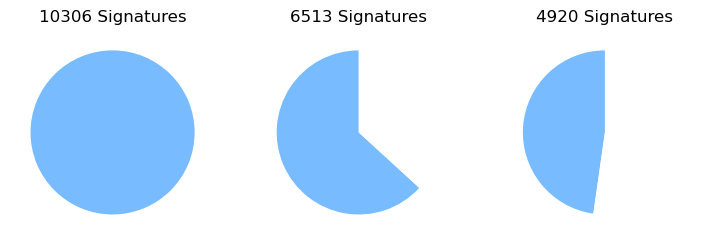

In [20]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = len(dsaids_common_gene_ids)
n_step_2 = len(dsaids_matrix)

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures")
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures")
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures")
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

plt.savefig(
    os.path.join(
        "..", "results", "figures", "DiSignAtlas", f"mesh.data_process.{sparsity}.png"
    ),
    bbox_inches="tight",
    dpi=300,
)

In [21]:
# get diseases of interest
dsaid_2_disease = dict(df_data_info_processed_filtered[["dsaid", "disease"]].values)


count_diseases = Counter([dsaid_2_disease[dsaid] for dsaid in dsaids_filtered_mesh])
diseases_to_check = [k for k, v in count_diseases.items() if v >= 5]
logging.info(f"Nº of most common diseases in df: {len(diseases_to_check)}")

# get disease to dsaids of interest
disease_2_dsaid_filtered = dict()

all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

# loop through all diseases
for disease, dsaid in zip(all_diseases, all_dsaids):
    # loop through diseases of interest
    # if disease in diseases_to_check:
    # check if dsaids are in matrix ids
    if dsaid in dsaids_matrix:
        if disease not in disease_2_dsaid_filtered.keys():
            disease_2_dsaid_filtered[disease] = list()
        disease_2_dsaid_filtered[disease].append(dsaid)


most_common_diseases = [k for k, v in disease_2_dsaid_filtered.items() if len(v) >= 5]

logging.info(f"Nº of most common diseases in matrix: {len(most_common_diseases)}")

2024-04-26 20:17:31,330 - INFO - Nº of most common diseases in df: 209
2024-04-26 20:17:31,516 - INFO - Nº of most common diseases in matrix: 209


<Figure size 450x400 with 0 Axes>

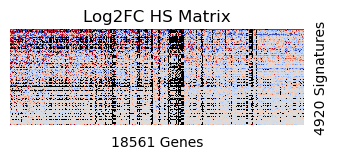

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4.5, 4))


# Set the color palette
cmap = sns.color_palette("coolwarm", as_cmap=True)
if metric_evaluated == "Ranking.AdjPValue":
    cmap = sns.color_palette("Reds", as_cmap=True)


cmap.set_bad(color="black")

if (
    (metric_evaluated == "AdjPValue")
    or (metric_evaluated == "PValue")
    or (metric_evaluated == "ReAdjPValue")
):
    min_val = 0
    max_val = 1
    cluster = True
elif "Log2FC" in metric_evaluated:
    min_val = -1.5
    max_val = 1.5
    cluster = True
elif metric_evaluated.startswith("iLINCS"):
    min_val = -10
    max_val = 10
    cluster = False
elif metric_evaluated == "Ranking.AdjPValue":
    min_val = 0
    max_val = 200
    cluster = False

elif metric_evaluated == "Ranking.Log2FC":
    min_val = -200
    max_val = 200
    cluster = False
elif metric_evaluated == "Significant.Log2FC":
    min_val = -100
    max_val = 100
    cluster = False


# subset data matrix

rows = np.random.choice(data_matrix.shape[0], 3000, replace=False)
cols = np.random.choice(data_matrix.shape[1], 3000, replace=False)

# Plot the clustermap without dendrograms and color bar
cg = sns.clustermap(
    data_matrix[rows][:, cols],
    cmap=cmap,
    mask=nan_mask[rows][:, cols],
    row_cluster=True,
    col_cluster=True,
    # dendrogram_ratio=(0.1, 0.1),  # Very small dendrogram size
    figsize=(4.5, 2),  # Control the size of the clustermap here
    cbar_pos=None,
    vmin=min_val,
    vmax=max_val,
)  # No color bar

# Suppress dendrograms
cg.ax_row_dendrogram.set_visible(False)  # suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False)  # suppress column dendrogram

# Remove x and y labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])

# Set axis labels
cg.ax_heatmap.set_xlabel(f"{len(most_common_gene_ids)} Genes")  # Set x-axis label
cg.ax_heatmap.set_ylabel(f"{len(dsaids_matrix)} Signatures")  # Set y-axis label

cg.ax_heatmap.tick_params(axis="both", which="both", length=0)  # Remove tick lines

plt.title(f"{metric_evaluated} {sparsity} Matrix")

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.cluster_map.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

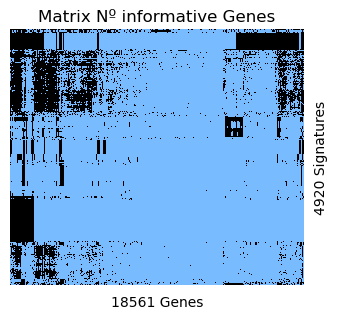

In [23]:
from matplotlib.colors import ListedColormap

# Define a custom color map: 1s in blue, 0s in black
cmap = sns.color_palette("light:b", as_cmap=True)
cmap.set_bad(color="black")


_data_matrix = data_matrix.copy()
_data_matrix = np.ones_like(_data_matrix)
_data_matrix[nan_mask] = 0

# Define a custom color map: 1s in blue, 0s in black, NaNs in gray
cmap = ListedColormap(["black", "#78bcff"])
cmap.set_bad("gray", 1.0)  # Handle NaN values, setting them to gray

# Randomly select rows and columns
rows = np.random.choice(data_matrix.shape[0], 3000, replace=False)
cols = np.random.choice(data_matrix.shape[1], 3000, replace=False)


# Plot the cluster map without applying nan_mask as mask parameter since we've handled NaNs
cg = sns.clustermap(
    _data_matrix[rows][:, cols],
    cmap=cmap,
    figsize=(4.5, 4),
    cbar_pos=None,
    col_cluster=True,
    row_cluster=True,
    vmin=0,  # Minimum value for color mapping
    vmax=1,  # Maximum value for color mapping
)


# Suppress dendrograms
cg.ax_row_dendrogram.set_visible(False)  # suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False)  # suppress column dendrogram

# Remove x and y labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])

# Set axis labels
cg.ax_heatmap.set_xlabel(f"{len(most_common_gene_ids)} Genes")  # Set x-axis label
cg.ax_heatmap.set_ylabel(f"{len(dsaids_matrix)} Signatures")  # Set y-axis label

cg.ax_heatmap.tick_params(axis="both", which="both", length=0)  # Remove tick lines
# plt.title("%s Matrix" % {"LS": "Low Sparsity", "HS": "High Sparsity"}[sparsity])
plt.title(f"Matrix Nº informative Genes")

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.cluster_map.nans.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

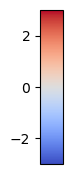

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# Set min and max values based on 'metric_evaluated'
if (
    (metric_evaluated == "AdjPValue")
    or (metric_evaluated == "PValue")
    or (metric_evaluated == "ReAdjPValue")
):
    min_val = 0
    max_val = 1
elif "Log2FC" in metric_evaluated:
    min_val = -3
    max_val = 3
elif metric_evaluated.startswith("iLINCS"):
    min_val = -10
    max_val = 10
elif metric_evaluated == "Ranking.AdjPValue":
    min_val = 0
    max_val = 200
elif metric_evaluated == "Ranking.Log2FC":
    min_val = -200
    max_val = 200
elif metric_evaluated == "Significant.Log2FC":
    min_val = -100
    max_val = 100

# Set the color palette
cmap = sns.color_palette("coolwarm", as_cmap=True)
if metric_evaluated == "Ranking.AdjPValue":
    cmap = sns.color_palette("Reds", as_cmap=True)


# Create a figure for the color bar
fig, ax = plt.subplots(figsize=(0.3, 2))

# Create a scalar mappable for the color bar
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can safely ignore this line as it's just to avoid warnings

# Create the color bar
cbar = plt.colorbar(sm, cax=ax)

# Set the label of the color bar based on the metric evaluated
# cbar.set_label(metric_evaluated)

# Move color bar tick labels and lines to the left
cbar.ax.yaxis.set_ticks_position("left")  # This moves tick lines to the left
cbar.ax.yaxis.set_label_position(
    "left"
)  # This ensures the label is aligned with the ticks
cbar.ax.yaxis.set_tick_params(
    labelleft=True, labelright=False
)  # Adjusts labels to the left


# Save the color bar as a separate figure
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.cbar_{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

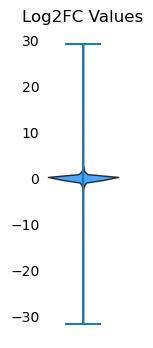

In [25]:
# plot value distribution

values = [np.min(data_matrix)]
values.append(np.max(data_matrix))
values.extend(np.random.choice(data_matrix.flatten(), 5000, replace=False))


plt.figure(figsize=(1, 4))
violin_parts = plt.violinplot(
    values,
    showmeans=False,
    showmedians=False,
    showextrema=True,  # Hides the min, max, median, and mean indicators
)


# Customize the appearance of the violin plot
violin_parts["bodies"][0].set_facecolor("#1E90FF")
violin_parts["bodies"][0].set_edgecolor("black")
violin_parts["bodies"][0].set_alpha(0.8)

# remove y ticks
plt.xticks([])
plt.tick_params(
    axis="y", which="both", length=0
)  # Set the tick length to 0 for the y-axis

# Remove the spines of the top, bottom, and left
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Move y-axis ticks to the right
# plt.gca().yaxis.tick_right()
title = f"{metric_evaluated} Values"
if metric_evaluated == "Log2FC":
    title = f"{metric_evaluated} Values"

if len(title) > 22:
    plt.title(title[:16] + "...", ha="center")
else:
    plt.title(title, ha="center")


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.value_distribution.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

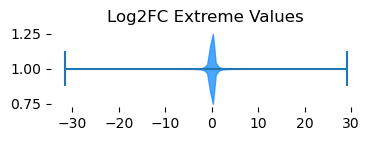

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assume 'data_matrix' and 'metric_evaluated' are defined
# Compute percentiles to focus on extreme values
values = data_matrix.flatten()

# Create the violin plot horizontally
plt.figure(figsize=(4, 1))  # Adjusted aspect ratio for horizontal plot
violin_parts = plt.violinplot(
    values,
    vert=False,  # Make the plot horizontal
    showmeans=False,
    showmedians=False,
    showextrema=True,
)

# Customize the appearance
violin_parts["bodies"][0].set_facecolor("#1E90FF")
violin_parts["bodies"][0].set_edgecolor("#1E90FF")
violin_parts["bodies"][0].set_alpha(0.8)

# Remove x ticks and adjust y ticks to the right
# plt.yticks([])
# plt.tick_params(axis="x", which="both", length=0)

# Remove the spines
for spine in ["top", "bottom", "left", "right"]:
    plt.gca().spines[spine].set_visible(False)

# Adjust title based on length
title = f"{metric_evaluated} Extreme Values"
if len(title) > 22:
    plt.title(title[:16] + "...", ha="center")
else:
    plt.title(title, ha="center")

# Specify file path and save
file_path = os.path.join(
    "..",
    "results",
    "figures",
    "DiSignAtlas",
    f"mesh.violinplot.extreme.{metric_evaluated}.png",
)
plt.savefig(file_path, dpi=300, bbox_inches="tight")

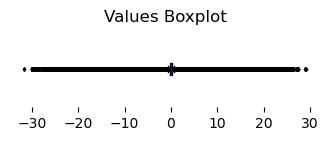

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assume 'data_matrix' and 'metric_evaluated' are defined
# Flatten the data matrix to prepare for plotting
values = data_matrix.flatten()

# Create the boxplot horizontally
plt.figure(figsize=(4, 1))  # Adjusted aspect ratio for horizontal plot
box_parts = plt.boxplot(
    values,
    vert=False,  # Make the plot horizontal
    showmeans=False,  # Decide if the mean should be shown
    showcaps=True,  # Shows the caps on the whiskers
    patch_artist=True,  # Necessary for customizing colors
    flierprops={
        "marker": "d",
        "markerfacecolor": "black",
        "markersize": 2,
        "markeredgecolor": "black",
    },
)

# Customize the appearance
box_parts["boxes"][0].set_facecolor("#1E90FF")
box_parts["boxes"][0].set_edgecolor("black")
box_parts["medians"][0].set_color("midnightblue")  # Customize the median line color

# Remove x ticks and adjust y ticks
plt.yticks([])  # Remove x ticks if unnecessary
plt.tick_params(axis="y", which="both", length=0)  # Adjust tick parameters

# Remove the spines
for spine in ["top", "bottom", "left", "right"]:
    plt.gca().spines[spine].set_visible(False)

# Adjust title based on length
title = "Values Boxplot"
if len(title) > 22:
    plt.title(title[:16] + "...", ha="center")
else:
    plt.title(title, ha="center")

# Uncomment the following lines if you wish to save the plot
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.boxplot.value_distribution.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [28]:
np.max(data_matrix.flatten())

29.0688215896224

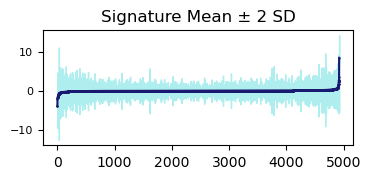

In [29]:
import numpy as np
import matplotlib.pyplot as plt

log_scale = False
n_std = 2
# Calculate means and standard deviations
means = data_matrix.mean(axis=1)
std_devs = n_std * data_matrix.std(axis=1)

# Sort columns by mean
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

# Create a plot
plt.figure(figsize=(4, 1.5))
plt.plot(
    range(data_matrix.shape[0]),
    sorted_means,
    "o-",
    label="Mean",
    color="midnightblue",
    markersize=0.7,
)
plt.fill_between(
    range(data_matrix.shape[0]),
    sorted_means - sorted_std_devs,
    sorted_means + sorted_std_devs,
    color="paleturquoise",
    alpha=1,
    label=f"Mean ± {n_std} SD",
)

if log_scale:
    plt.yscale("symlog")
    plt.title(f"Signature Mean ± {n_std} SD (log scale)")
else:
    plt.title(f"Signature Mean ± {n_std} SD")
# plt.xlabel("Columns (sorted)")
plt.yticks(fontsize=8)
# plt.xlim(0 - 100, data_matrix.shape[0] + 100)
plt.grid(False)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"value_signature.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

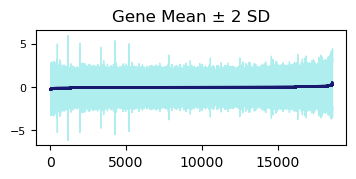

In [30]:
import numpy as np
import matplotlib.pyplot as plt

log_scale = False
n_std = 2
# Calculate means and standard deviations
means = data_matrix.mean(axis=0)
std_devs = n_std * data_matrix.std(axis=0)

# Sort columns by mean
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

# Create a plot
plt.figure(figsize=(4, 1.5))
plt.plot(
    range(data_matrix.shape[1]),
    sorted_means,
    "o-",
    label="Mean",
    color="midnightblue",
    markersize=0.7,
)
plt.fill_between(
    range(data_matrix.shape[1]),
    sorted_means - sorted_std_devs,
    sorted_means + sorted_std_devs,
    color="paleturquoise",
    alpha=1,
    label=f"Mean ± {n_std} SD",
)
if log_scale:
    plt.yscale("symlog")
    plt.title(f"Gene Mean ± {n_std} SD (log scale)")
else:
    plt.title(f"Gene Mean ± {n_std} SD")
# plt.xlabel("Columns (sorted)")
plt.yticks(fontsize=8)
# plt.ylabel("Mean Values")
# plt.legend()
plt.grid(False)
# plt.xlim(0 - 100, data_matrix.shape[1] + 100)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"value_gene.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

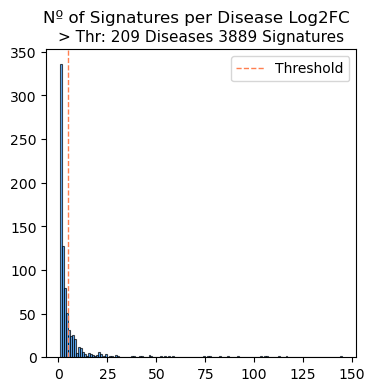

In [31]:
# plot nº of signatures per disease
values = [len(v) for v in disease_2_dsaid_filtered.values()]

# Recalculating based on the bin width of 1
bin_width = 1
min_bin = np.floor(np.min(values))
max_bin = np.ceil(np.max(values))
bins = np.arange(min_bin, max_bin + bin_width, bin_width)


plt.figure(figsize=(4, 4))
plt.hist(
    x=values, bins=bins, alpha=0.7, edgecolor="black", linewidth=0.8, color="#1E90FF"
)
plt.axvline(x=5, color="#FF7F50", linestyle="dashed", linewidth=1, label="Threshold")
title_txt = f"Nº of Signatures per Disease {metric_evaluated}"
title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
plt.suptitle(title_txt)
n_signatures_above_thr = sum(
    [len(v) for v in disease_2_dsaid_filtered.values() if len(v) >= 5]
)
plt.title(
    f"> Thr: {len(most_common_diseases)} Diseases {n_signatures_above_thr} Signatures",
    fontsize=11,
)
plt.legend()
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.n_signatures_per_disease.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [32]:
# count how many dsaids have data


# count how many dsaids have information
# count nans from the pre-computed matrix

### Compute Similarities

In [33]:
# imports
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
import random

# variables


#  functions
def generate_pairs_2_lists(interest_idxs, rest_idxs, bootstrap=False):
    """Generate pairs of indexes for a given list of indexes
    Arguments:
        - interest_idxs (list): list of indexes
        - rest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes
    """
    for idx_interest in interest_idxs:
        if bootstrap:
            rest_idxs = np.empty(len(interest_idxs) * 100, dtype=int)
            for i in range(100):
                _sample = np.random.choice(
                    rest_idxs, size=len(interest_idxs), replace=True
                )
                rest_idxs[i : (i + 1) * len(interest_idxs)] = _sample
        for idx_other in rest_idxs:
            if idx_interest != idx_other:
                if bootstrap:
                    yield np.array([idx_interest, idx_other], dtype=int)


def generate_pairs_1_list(interest_idxs, unique=True):
    """Generate pairs of indexes for a given list of indexes

    Generators are designed to be memory-efficient by generating
    items one at a time and not keeping them in memory. This means
    they do not have a length or size property like lists or arrays.

    Arguments:
        - interest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes

    """
    if not unique:
        for idx_i, element_i in enumerate(interest_idxs):
            for idx_j, element_j in enumerate(interest_idxs):
                if idx_i != idx_j:
                    yield np.array([element_i, element_j], dtype=int)
    if unique:
        for idx_i, element_i in enumerate(interest_idxs):
            for element_j in interest_idxs[idx_i + 1 :]:
                yield np.array([element_i, element_j], dtype=int)


def get_rest_indexes(interest_idxs, all_indexes, proportion=100):
    """Get rest indexes
    Arguments:
        - interest_idxs (list): list of indexes of interest
        - all_indexes (list): list of all indexes
        - n_random_indexes (int): nº of random indexes
    Returns:
        - random_rest_indexes (list): list of random indexes
    """
    import numpy as np

    # Get subset of indexes for rest
    all_rest_indexes = all_indexes - set(interest_idxs)

    # n_random_indexes
    n_random_indexes = (
        len(interest_idxs) * proportion
        if len(interest_idxs) * proportion < len(all_rest_indexes)
        else len(all_rest_indexes)
    )

    # random indexes withtout replacement - appear once
    random_rest_indexes = np.random.choice(
        list(all_rest_indexes), size=n_random_indexes, replace=False
    )

    return random_rest_indexes


def compute_euclidean_distance(data_matrix_1, data_matrix_2=None):
    """Compute Euclidean Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of Euclidean distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="euclidean")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="euclidean")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_cosine_distance(data_matrix_1, data_matrix_2=None):
    """Compute Cosine Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of cosine distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="cosine")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="cosine")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
        correlation_matrix = correlation_matrix[
            : data_matrix_1.shape[0], data_matrix_1.shape[0] :
        ]
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


def check_old_method_correlation(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]
    # Pearson Correlation
    correlation_matrix = np.corrcoef(matrix_interest)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return np.mean(correlation_values)


def check_old_method_cosine(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="cosine")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)


def check_old_method_euclidean(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="euclidean")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)


# compute metrics ONCE - after all we have to do is retrieve data
# pearson correlation
matrix_pearson_correlation = np.corrcoef(data_matrix)

# euclidean distance
_matrix_euclidean_distance = pdist(data_matrix, metric="euclidean")
matrix_euclidean_distance = squareform(_matrix_euclidean_distance)
# cosine distance
_matrix_cosine_distance = pdist(data_matrix, metric="cosine")
matrix_cosine_distance = squareform(_matrix_cosine_distance)

In [34]:
related_dsaids = []
for dsaid in dsaids_filtered_mesh:
    if dsaid in dsaids_2_mesh_tree_terms.keys():
        related_dsaids.extend(dsaids_2_mesh_tree_terms[dsaid])
unrrelated_dsaids = []

In [35]:
# def check_related_dsaids(, related_dsaids):

all_related_dsaids = list()
all_unrelated_dsaids = list()
# check that all same diseases are related through mesh terms
for count, disease in enumerate(
    tqdm(most_common_diseases)
):  # loop through diseases of interest
    # dsaids w/ diseases of interest
    related_dsaids = list()
    unrrelated_dsaids = list()
    dsaids_interest = disease_2_dsaid_filtered.get(disease)
    for dsaid in dsaids_interest:
        _dsaids_interest = dsaids_interest.copy()
        _dsaids_interest.remove(dsaid)
        _dsaids_interest_mesh_terms = list(
            {
                mesh_term
                for d in _dsaids_interest
                for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
            }
        )
        _dsaids_interest_mesh_terms = [d for d in _dsaids_interest_mesh_terms]

        dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
        dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
        # check if they are related
        switch = False
        for dsaid_mesh_term in dsaid_mesh_terms:
            if dsaid_mesh_term in _dsaids_interest_mesh_terms:
                switch = True
                break
        if switch:
            related_dsaids.append(dsaid)
        else:
            unrrelated_dsaids.append(dsaid)

    all_related_dsaids.append(related_dsaids)
    all_unrelated_dsaids.append(unrrelated_dsaids)

100%|██████████| 209/209 [00:00<00:00, 10640.01it/s]


In [36]:
[a for a, b in zip(most_common_diseases, all_unrelated_dsaids) if len(b) > 0]

[]

In [37]:
dsaids = disease_2_dsaid_filtered.get("Depression")
for dsaid in dsaids:
    print(dsaid, dsaids_2_mesh_tree_terms.get(dsaid, []))

DSA00787 ['F03.600.300']
DSA03519 ['F03.600.300']
DSA03522 ['F03.600.300']
DSA04490 ['F03.600.300']
DSA06870 ['F03.600.300']


In [38]:
def check_common_mesh_terms(list_1, list_2, level):
    """Check Common Mesh Terms
    Arguments:
        - list_1 (list): list of mesh terms
        - list_2 (list): list of mesh terms
        - level (int): level of mesh terms
    Returns:
        - (bool): True if common mesh terms
    """
    list_1 = [
        ".".join(l.split(".")[:level]) for l in list_1 if len(l.split(".")) >= level
    ]
    list_2 = [
        ".".join(l.split(".")[:level]) for l in list_2 if len(l.split(".")) >= level
    ]
    if len(set(list_1).intersection(set(list_2))) > 0:
        return True
    else:
        return False

In [39]:
def check_mesh_level(list_1, level):
    """Check Common Mesh Terms
    Arguments:
        - list_1 (list): list of mesh terms
        - level (int): mesh level - 1 is root
    Returns:
        - (bool): True if common mesh terms
    """
    list_1 = [
        ".".join(l.split(".")[:level]) for l in list_1 if len(l.split(".")) >= level
    ]
    if len(list_1) >= 1:
        return True
    else:
        return False

In [40]:
c = 0
level = 7
for count, disease in enumerate(
    tqdm(most_common_diseases)
):  # loop through diseases of interest
    # dsaids w/ diseases of interest
    related_dsaids = list()
    unrrelated_dsaids = list()
    dsaids_interest = disease_2_dsaid_filtered.get(disease)
    _dsaids_interest_mesh_terms = list(
        {
            mesh_term
            for d in dsaids_interest
            for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
        }
    )
    if check_mesh_level(_dsaids_interest_mesh_terms, level=level):
        # print(disease)
        c += 1

print(c)

100%|██████████| 209/209 [00:00<00:00, 136564.81it/s]

41


In [41]:
def generate_matrix_idxs(interest_idxs, rest_idxs=None, bootstrap=False):
    """Generate pairs of indexes for a given list of indexes
    Arguments:
        - interest_idxs (list): list of indexes
        - rest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes
    """

    if rest_idxs is None:  # generate idxs agains itself
        matrix = np.empty((len(interest_idxs), len(interest_idxs) - 1, 2), dtype=int)
        rest_idxs = interest_idxs
    else:
        matrix = np.empty((len(interest_idxs), len(rest_idxs), 2), dtype=int)

    if bootstrap:
        # this is bc when we compare same samples we
        # remove itself - so we do the same here
        n_sample_idxs = len(interest_idxs)
        matrix = np.empty((len(interest_idxs), n_sample_idxs * 100, 2), dtype=int)
        # generate bootstrap indexes
        sample_idxs = np.empty(n_sample_idxs * 100, dtype=int)
        for i in range(100):
            _sample = np.random.choice(rest_idxs, size=n_sample_idxs, replace=True)
            sample_idxs[i * n_sample_idxs : (i + 1) * n_sample_idxs] = _sample

        # redefine rest indexes
        rest_idxs = sample_idxs

    for i, idx_interest in enumerate(interest_idxs):
        j = 0
        for idx_other in rest_idxs:
            if idx_interest != idx_other:  # in case that it is the same list
                matrix[i, j] = [idx_interest, idx_other]
                j += 1
    return matrix

In [151]:
# variables
k_top = 1
k_percent = 0.2
mesh_level = 1
bootstrap = True
n_diseases = 0

correlation_values_interest_all = list()
correlation_values_related_all = list()
correlation_values_unrelated_all = list()

cosine_values_interest_all = list()
cosine_values_related_all = list()
cosine_values_unrelated_all = list()

euclidean_values_interest_all = list()
euclidean_values_related_all = list()
euclidean_values_unrelated_all = list()

# get values
quality_check = random.choice(list(range(len(most_common_diseases))))
logging.info(f"Quality check: {quality_check} {most_common_diseases[quality_check]}")

all_indexes = set(range(data_matrix.shape[0]))

for count, disease in enumerate(tqdm(most_common_diseases)):

    # dsaids w/ diseases of interest
    dsaids_interest = disease_2_dsaid_filtered.get(disease)

    related_dsaids = list()
    unrelated_dsaids = list()

    # get mesh terms
    _dsaids_interest_mesh_terms = list(
        {
            mesh_term
            for d in dsaids_interest
            for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
        }
    )

    if check_mesh_level(_dsaids_interest_mesh_terms, level=mesh_level):

        # Extract the specific vectors using the list of indexes
        interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

        # interest indexes pairs
        """We have a list of lists in which we have
        for each disease signature of interest (row of a matrix) a list in which 
        we will have all the combination of pairs"""

        n_interest = len(interest_idxs)

        # compute how many pairs we will have
        n_interest_unique = int(n_interest * (n_interest - 1) / 2)
        n_interest_all = int(n_interest * n_interest)

        interest_idxs_pairs = np.empty((n_interest, n_interest - 1, 2), dtype=int)
        interest_idxs_pairs_unique = np.empty((n_interest_unique, 2), dtype=int)

        # generate pairs (all vs all)
        matrix_interest_idxs_pairs = generate_matrix_idxs(
            interest_idxs, bootstrap=False
        )

        # define matrix to store values
        matrix_correlation_values_interest = np.empty(
            (n_interest, n_interest - 1), dtype=float
        )

        matrix_cosine_values_interest = np.empty(
            (n_interest, n_interest - 1), dtype=float
        )

        matrix_euclidean_values_interest = np.empty(
            (n_interest, n_interest - 1), dtype=float
        )

        # itereate through all interest signatures
        for i, row_interest in enumerate(matrix_interest_idxs_pairs):
            # get values
            correlation_values_interest = matrix_pearson_correlation[
                row_interest[:, 0], row_interest[:, 1]
            ]
            cosine_values_interest = matrix_cosine_distance[
                row_interest[:, 0], row_interest[:, 1]
            ]
            euclidean_values_interest = matrix_euclidean_distance[
                row_interest[:, 0], row_interest[:, 1]
            ]

            # store values
            matrix_correlation_values_interest[i] = correlation_values_interest
            matrix_cosine_values_interest[i] = cosine_values_interest
            matrix_euclidean_values_interest[i] = euclidean_values_interest

        # quality check
        if count == quality_check:

            # check pearson correlation
            old_value_correlation = check_old_method_correlation(
                dsaids_interest, data_matrix
            )
            assert "%.7f" % old_value_correlation == "%.7f" % np.mean(
                matrix_correlation_values_interest
            ), "Err something wrong computing correlation"

            # check cosine distance
            old_value_cosine = check_old_method_cosine(dsaids_interest, data_matrix)
            assert "%.7f" % old_value_cosine == "%.7f" % np.mean(
                matrix_cosine_values_interest
            ), "Err something wrong computing cosine"
            # check euclidean distance
            old_value_euclidean = check_old_method_euclidean(
                dsaids_interest, data_matrix
            )
            assert "%.7f" % old_value_euclidean == "%.7f" % np.mean(
                matrix_euclidean_values_interest
            ), "Err something wrong computing euclidean"

        # get rest indexes
        # get ids of rest
        _rest_dsaids = list(set(dsaids_matrix) - set(dsaids_interest))

        # classify rest of ids into related or unrelated
        for dsaid in _rest_dsaids:
            dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
            dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
            # check if they are related
            if check_common_mesh_terms(
                list_1=_dsaids_interest_mesh_terms,
                list_2=dsaid_mesh_terms,
                level=mesh_level,
            ):
                related_dsaids.append(dsaid)

            else:
                unrelated_dsaids.append(dsaid)
        if len(related_dsaids) > 0:
            n_diseases += 1
            # get idx position related and unrelated
            related_idxs = [dsaids_matrix.index(d) for d in related_dsaids]
            unrelated_idxs = [dsaids_matrix.index(d) for d in unrelated_dsaids]

            # get nº
            n_related = len(related_idxs)
            n_unrelated = len(unrelated_idxs)

            # generate matrix indexes pairs
            matrix_related_idxs_pairs = generate_matrix_idxs(
                interest_idxs, related_idxs, bootstrap=bootstrap
            )
            matrix_unrelated_idxs_pairs = generate_matrix_idxs(
                interest_idxs, unrelated_idxs, bootstrap=bootstrap
            )

            # define matrix to store values
            n_columns = (n_interest) * 100 if bootstrap else n_related
            matrix_correlation_values_related = np.empty(
                (n_interest, n_columns), dtype=float
            )
            matrix_cosine_values_related = np.empty(
                (n_interest, n_columns), dtype=float
            )
            matrix_euclidean_values_related = np.empty(
                (n_interest, n_columns), dtype=float
            )

            # iterate through all interest signature pairs
            for idx, row_related in enumerate(matrix_related_idxs_pairs):

                # get values
                correlation_values_related = matrix_pearson_correlation[
                    row_related[:, 0], row_related[:, 1]
                ]
                cosine_values_related = matrix_cosine_distance[
                    row_related[:, 0], row_related[:, 1]
                ]
                euclidean_values_related = matrix_euclidean_distance[
                    row_related[:, 0], row_related[:, 1]
                ]

                # store values
                matrix_correlation_values_related[idx] = correlation_values_related
                matrix_cosine_values_related[idx] = cosine_values_related
                matrix_euclidean_values_related[idx] = euclidean_values_related

            # define matrix to store values
            n_columns = (n_interest) * 100 if bootstrap else n_unrelated
            matrix_correlation_values_unrelated = np.empty(
                (n_interest, n_columns), dtype=float
            )
            matrix_cosine_values_unrelated = np.empty(
                (n_interest, n_columns), dtype=float
            )
            matrix_euclidean_values_unrelated = np.empty(
                (n_interest, n_columns), dtype=float
            )

            # iterate through all interest signature pairs to find top closest
            for idx, row_unrelated in enumerate(matrix_unrelated_idxs_pairs):

                # get correlation values
                correlation_values_unrelated = matrix_pearson_correlation[
                    row_unrelated[:, 0], row_unrelated[:, 1]
                ]
                cosine_values_unrelated = matrix_cosine_distance[
                    row_unrelated[:, 0], row_unrelated[:, 1]
                ]
                euclidean_values_unrelated = matrix_euclidean_distance[
                    row_unrelated[:, 0], row_unrelated[:, 1]
                ]

                # get matrix to store values
                matrix_correlation_values_unrelated[idx] = correlation_values_unrelated
                matrix_cosine_values_unrelated[idx] = cosine_values_unrelated
                matrix_euclidean_values_unrelated[idx] = euclidean_values_unrelated

            # store all computed values
            correlation_values_interest_all.append(matrix_correlation_values_interest)
            correlation_values_related_all.append(matrix_correlation_values_related)
            correlation_values_unrelated_all.append(matrix_correlation_values_unrelated)

            cosine_values_interest_all.append(matrix_cosine_values_interest)
            cosine_values_related_all.append(matrix_cosine_values_related)
            cosine_values_unrelated_all.append(matrix_cosine_values_unrelated)

            euclidean_values_interest_all.append(matrix_euclidean_values_interest)
            euclidean_values_related_all.append(matrix_euclidean_values_related)
            euclidean_values_unrelated_all.append(matrix_euclidean_values_unrelated)

assert (
    n_diseases
    == len(correlation_values_interest_all)
    == len(correlation_values_unrelated_all)
), "Err something wrong with the length of the lists"

logging.info(f"Nº diseases evaluated {n_diseases}")

2024-04-26 21:08:15,927 - INFO - Quality check: 92 IgA Nephropathy
100%|██████████| 209/209 [00:40<00:00,  5.17it/s]
2024-04-26 21:08:56,393 - INFO - Nº diseases evaluated 209


In [43]:
# get total nº of diseases w/ 5+ signatures
n_processed_filtered = 0
for disease in df_data_info_processed_filtered["disease"].unique():
    QUERY = f"disease == @disease"
    df_query = df_data_info_processed_filtered.query(f"disease == @disease")
    if df_query.shape[0] >= 5:
        n_processed_filtered += 1

logging.info(f"Nº of disease 5+ signatures {n_processed_filtered}")

2024-04-26 20:24:22,356 - INFO - Nº of disease 5+ signatures 276


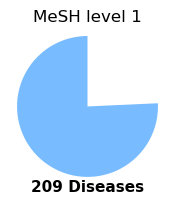

In [44]:
# plot how many diseases we are evaluating here
n_processed_filtered
n_diseases

# Data preparation
sizes = [n_diseases, n_processed_filtered - n_diseases]  # Sizes for each slice

# Colors, setting the non-relevant slice to be 'none' (transparent)
colors = ["#78bcffff", "none"]

# Plotting the pie chart
plt.figure(figsize=(2, 2))  # Set the figure size
plt.pie(sizes, colors=colors, startangle=90)
plt.title(f"MeSH level {mesh_level}", fontsize=12)

plt.text(
    -0.8, -1.2, f"{n_diseases} Diseases", fontsize=11, fontweight="bold"
)  # Big title
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pie_chart.mesh_{mesh_level}.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [45]:
dsaids_2_disease = {v: k for k, vs in disease_2_dsaid_filtered.items() for v in vs}

diseases_matrix = [dsaids_2_disease.get(d) for d in dsaids_matrix]

In [46]:
most_common_diseases[1]

# get disease of interest
dsaids_interest = disease_2_dsaid_filtered.get(most_common_diseases[1])

index = [dsaids_matrix.index(d) for d in dsaids_interest]

# get matrix values
values = matrix_pearson_correlation[index, :]

In [47]:
[
    a
    for a in np.where(matrix_cosine_distance[370] > 1.8, diseases_matrix, None)
    if a is not None
]

['Sepsis',
 'Acute Myeloid Leukemia',
 'Ulcerative Colitis',
 'Chronic Obstructive Pulmonary Disease']

In [48]:
# garbage collection
# do a bit of cleaning here and there !
import gc

# collect garbage
cleaning = gc.collect()

cleaning

20545

### Plots

In [49]:
# imports
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline


# functions
def get_top_k(array, k, percent=False, reverse=False):
    """Get top k values
    Arguments:
        - array (numpy): array of values
        - k_percent (float): percentage of top k values
    Returns:
        - top_k_values (numpy): array of top k values
    """
    if percent:
        k = round(k * array.shape[0])
    if reverse:
        # Using numpy.argsort to get indices of the k top highest values
        indices = np.argsort(array)[:k]

        # # Sorting indices if you want them in the order of the corresponding values
        # sorted_indices = indices[np.argsort(array[indices])][::-1]

        # Getting the top k values using the sorted indices
        # top_k_values_from_indices = array[sorted_indices]
        bottom_k_values_from_indices = array[indices]
        return bottom_k_values_from_indices
    else:
        # Using numpy.argsort to get indices of the k top highest values
        indices = np.argsort(array)[-k:]

        # # Sorting indices if you want them in the order of the corresponding values
        # sorted_indices = indices[np.argsort(array[indices])][::-1]

        # Getting the top k values using the sorted indices
        # top_k_values_from_indices = array[sorted_indices]
        top_k_values_from_indices = array[indices]
        return top_k_values_from_indices

In [50]:
def flatten(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]


def create_composite_histogram(distributions, bin_edges, is_list=False):
    """
    Create a composite histogram from multiple distributions.

    Parameters:
    - distributions: List of arrays, each representing a distribution of points.
    - bin_edges: Array of bin edges to use for all histograms.

    Returns:
    - composite_histogram: The composite histogram (sum of normalized histograms).
    """
    # Initialize an array to hold the sum of all normalized histograms
    counts_composite_histogram = np.zeros_like(bin_edges[:-1], dtype=float)

    # Iterate over each distribution
    for dist in distributions:
        if is_list:
            dist_values = flatten(dist)
        else:
            dist_values = dist.flatten()
        # Calculate the histogram for this distribution
        counts, _ = np.histogram(dist_values, bins=bin_edges)

        # Normalize the histogram by the number of points in the distribution
        normalized_counts = counts / len(dist_values)

        # Add the normalized histogram to the composite histogram
        counts_composite_histogram += normalized_counts

    return counts_composite_histogram

In [51]:
def format_p_value_std(mean, std):
    """Format the mean and standard deviation. Append an asterisk if mean < 0.05."""
    formatted_mean = f"{mean:.4e}" if mean < 0.0001 else f"{mean:.4f}"
    formatted_std = f"{std:.4e}" if std < 0.0001 else f"{std:.4f}"
    return f"{formatted_mean}±{formatted_std}" + ("*" if mean < 0.05 else "")


def format_p_value(mean):
    """Format the mean and standard deviation. Append an asterisk if mean < 0.05."""
    formatted_mean = f"{mean:.4e}" if mean < 0.0001 else f"{mean:.4f}"
    return f"{formatted_mean}" + ("*" if mean < 0.05 else "")


def get_ks_statistics_all(list_matrix_1, list_matrix_2):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_mean = np.mean(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )
    ks_p_values_std = np.std(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )

    return ks_p_values_mean, ks_p_values_std


def plot_metrics(
    values_list,
    ks_values_list,
    labels,
    vector_type,
    metric_list,
    mesh_level,
    cap_value=None,
    save=True,
    sparsity="HS",
    figsize=(4.5, 3),
    values_per_disease=True,
):

    # define variables

    colors = {0: "#FF7F50", 1: "#AFEAAA", 2: "#1E90FF"}
    colors = {0: "#FE8402", 1: "#87E293", 2: "#1E90FF"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1.01, 0.05),
        "pearson": np.arange(-1, 1.01, 0.05),
        "cosine": np.arange(0, 2.01, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }

    fixed_bins = fixed_bins_dict.get(metric)
    print(metric)
    print(fixed_bins)
    plt.figure(figsize=figsize)

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        alpha = 0.5
        if i == 0:
            alpha = 0.5

        if values_per_disease:
            # compute normalized density counts for each distribution
            counts = create_composite_histogram(values, fixed_bins)
        else:
            counts, _ = np.histogram(values, bins=fixed_bins)
            counts = counts / len(values)

        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt

    # Formatting each p-value mean and std, and constructing parts of the title

    formatted_parts = [format_p_value_std(mean, std) for mean, std in ks_values_list]

    # Constructing the full title
    title = (
        "Same-Related KS p-value: {}\n"
        "Same-Unrelated KS p-value: {}\n"
        "Related-Unrelated KS p-value: {}"
    ).format(*formatted_parts)

    plt.title(title, fontsize=10)
    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}.{filtering}.mesh_{mesh_level}.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )

In [52]:
np.max(np.arange(-1, 1.01, 0.05))

1.0000000000000018

In [53]:
def get_ks_statistics_subsamples_all(
    list_matrix_1, list_matrix_2, resampling_1=False, resampling_2=True
):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_means = list()
    for i in range(len(list_matrix_1)):
        # mean of statistics within a diseases
        if resampling_1 & resampling_2:
            ks_p_values_mean_disease = np.mean(
                [
                    ks_2samp(s_p_1, s_p_2.flatten())[1]
                    for (s_p_1, s_p_2) in zip(list_matrix_1[i], list_matrix_2[i])
                ]
            )
        elif resampling_2 & (not resampling_1):
            p_1 = list_matrix_1[i].flatten()
            ks_p_values_mean_disease = np.mean(
                [ks_2samp(p_1, s_p_2.flatten())[1] for s_p_2 in list_matrix_2[i]]
            )
        elif (not resampling_1) & (not resampling_2):
            p_1 = list_matrix_1[i].flatten()
            p_2 = list_matrix_2[i].flatten()
            ks_p_values_mean_disease = ks_2samp(p_1, p_2)[1]

        ks_p_values_means.append(ks_p_values_mean_disease)

    ks_p_values_mean_of_means = np.mean(ks_p_values_means)
    ks_p_values_std_of_means = np.std(ks_p_values_means)

    return ks_p_values_mean_of_means, ks_p_values_std_of_means

In [54]:
ks_2samp(
    correlation_values_interest_all[0].flatten(),
    correlation_values_interest_all[0].flatten(),
)[1]

1.0

#### Pearson Correlations

In [55]:
# pearson correlation all
# Correlation values mean with
value_1 = correlation_values_interest_all
value_2 = correlation_values_related_all
value_3 = correlation_values_unrelated_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Compute KS statistics
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=correlation_values_interest_all,
    list_matrix_2=correlation_values_related_all,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=correlation_values_interest_all,
    list_matrix_2=correlation_values_unrelated_all,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=correlation_values_related_all,
    list_matrix_2=correlation_values_unrelated_all,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]
fixed_bins = np.arange(-1.001, 1.001, 0.05)

2024-04-26 20:24:25,179 - INFO - Nº of values: 209 209


pearson
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]
p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01 

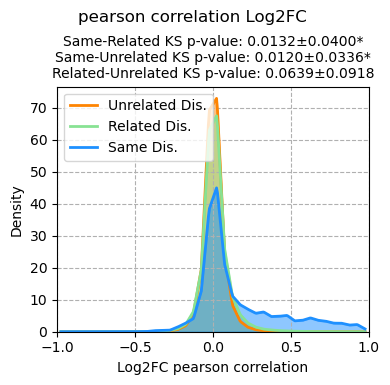

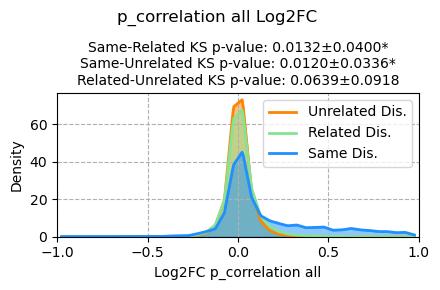

In [56]:
plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["pearson", "correlation"],
    save=True,
    mesh_level=mesh_level,
    figsize=(4, 4),
)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "all"],
    save=True,
    mesh_level=mesh_level,
)

2024-04-26 20:27:26,039 - INFO - Nº of values: 209 209


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


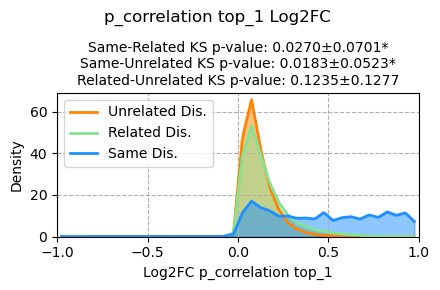

In [57]:
# pearson correlation top_1
# define values
top_k = 1

value_1 = list()
for matrix in correlation_values_interest_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=False)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in correlation_values_related_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in correlation_values_unrelated_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# define statistics
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_1"],
    save=True,
    mesh_level=mesh_level,
)

2024-04-26 20:28:17,035 - INFO - Nº of values: 209 209


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


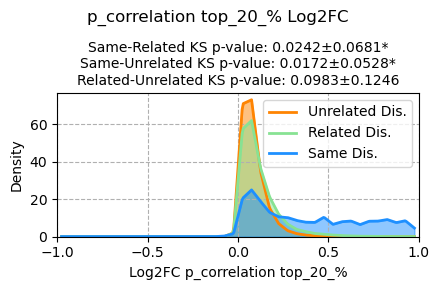

In [58]:
# pearson correlation top_20_%
# define values
top_k = 0.2

value_1 = list()
for matrix in correlation_values_interest_all:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in correlation_values_related_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in correlation_values_unrelated_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# define statistics
# define statistics
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]
fixed_bins = np.arange(-1.001, 1.001, 0.05)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_20_%"],
    save=True,
    mesh_level=mesh_level,
)

2024-04-26 20:28:57,967 - INFO - Nº of values: 209 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


2024-04-26 20:29:00,824 - INFO - Nº of values: 209 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


2024-04-26 20:29:03,783 - INFO - Nº of values: 209 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


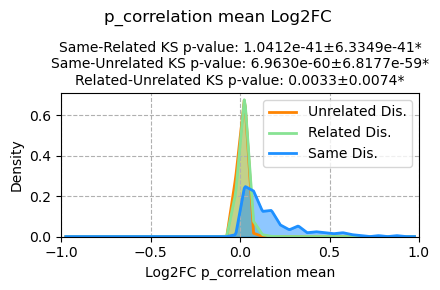

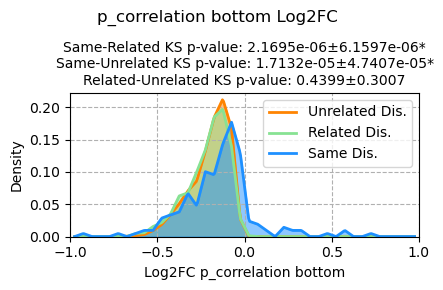

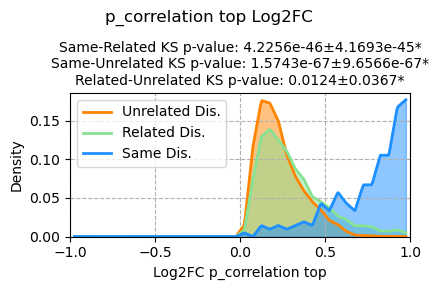

In [59]:
# pearson correlation mean
# define values
operation_d = {"mean": np.mean, "bottom": np.min, "top": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_1 = [
        operation(matrix.flatten()) for matrix in correlation_values_interest_all
    ]

    value_2 = [[] for _ in range(100)]
    for matrix in correlation_values_related_all:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in correlation_values_unrelated_all:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_2[i])[1])
    ks_p_values_i_r_mean, ks_p_values_i_r_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_3[i])[1])
    ks_p_values_i_u_mean, ks_p_values_i_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_2[i], value_3[i])[1])
    ks_p_values_r_u_mean, ks_p_values_r_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [flatten(value_3), flatten(value_2), value_1]
    ks_values_list = [
        [ks_p_values_i_r_mean, ks_p_values_i_r_std],
        [ks_p_values_i_u_mean, ks_p_values_i_u_std],
        [ks_p_values_r_u_mean, ks_p_values_r_u_std],
    ]

    labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["p_correlation", operation_type],
        save=True,
        mesh_level=mesh_level,
        values_per_disease=False,
    )

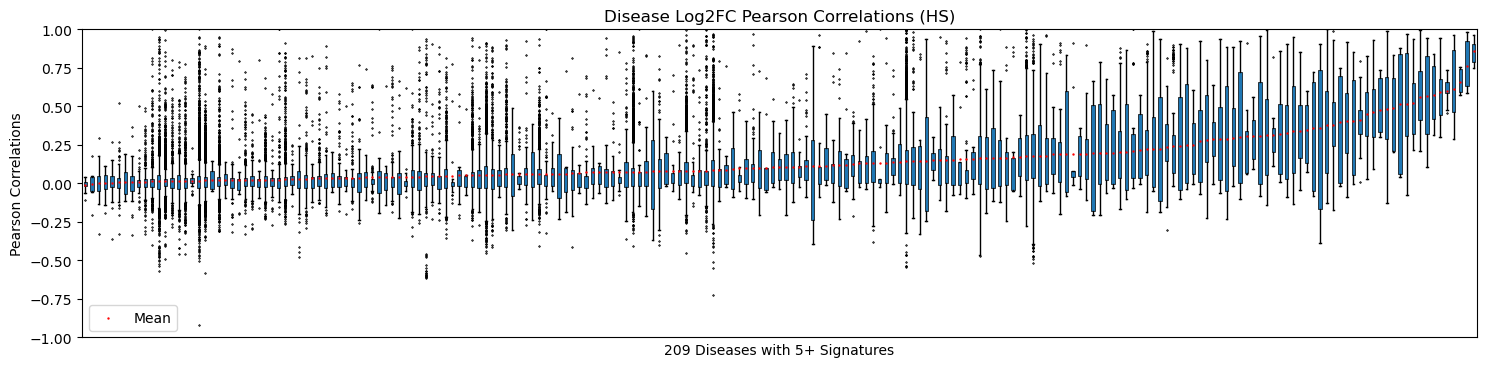

In [60]:
# Plot Disease Pearson Correlations Boxplots
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = correlation_values_interest_all
# Calculate means and sort data based on these means
means = [np.mean(i) for i in data]
sorted_indices = np.argsort(means)
sorted_data = [data[i].flatten() for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_diseases = [most_common_diseases[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(18, 4))  # Adjusted for visibility

flierprops = dict(marker=".", color="black", markersize=0.8)  # Customizing outliers
boxprops = dict(linestyle="solid", linewidth=0.5, color="black")
medianprops = dict(linestyle="-", linewidth=0)
# Boxplot
bp = plt.boxplot(
    sorted_data,
    vert=True,
    patch_artist=True,
    positions=range(1, int(len(sorted_means) / 1) + 1),
    flierprops=flierprops,
    boxprops=boxprops,
    medianprops=medianprops,
    # Apply outlier customization
)  # Adjusted for visibility

# Overlay means
plt.scatter(
    range(1, int(len(sorted_means) / 1) + 1),
    sorted_means,
    color="red",
    zorder=3,
    label="Mean",
    s=0.5,
)  # Adjusted for visibility

# Customization
plt.title(f"Disease {metric_evaluated} Pearson Correlations ({sparsity})")
plt.xlabel(f"{len(means)} Diseases with 5+ Signatures")
plt.ylabel("Pearson Correlations")
plt.xticks([])
plt.legend()
plt.ylim(-1, 1)

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"boxplot.diseases_correlation.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

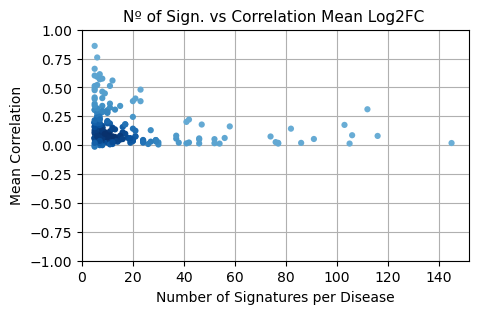

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = [np.mean(i) for i in correlation_values_interest_all]

# number of signatures per disease
n_signatures_per_disease = [
    len(disease_2_dsaid_filtered.get(disease)) for disease in most_common_diseases
]

# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)


# Plot
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)


# Customization
plt.grid(True, zorder=-1)  # Add gridlines
title_txt = f"Nº of Sign. vs Correlation Mean {metric_evaluated} "
title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
plt.title(title_txt, fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Correlation")

plt.ylim(-1, 1)
plt.xlim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.correlation.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Euclidean Distances

In [62]:
# define values
step = 25
cap_val = (
    500
    if 500 < np.max(matrix_euclidean_distance)
    else np.max(matrix_euclidean_distance) + 1
)


# Function to cap values at a specific limit
def cap_values_at_limit(values, limit):
    return np.where(values > limit, limit, values)

2024-04-26 20:29:08,791 - INFO - Nº of values: 209 209


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]
euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460.

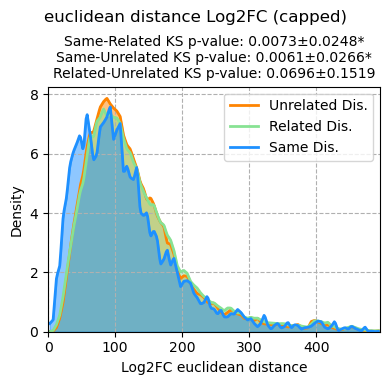

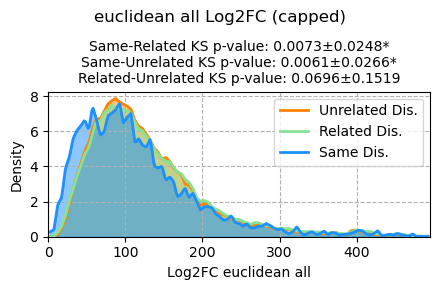

In [63]:
# euclidean all
value_1 = euclidean_values_interest_all
value_2 = euclidean_values_related_all
value_3 = euclidean_values_unrelated_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Cap the values for each list
capped_value_1 = [cap_values_at_limit(v, cap_val) for v in value_1]
capped_value_2 = [cap_values_at_limit(v, cap_val) for v in value_2]
capped_value_3 = [cap_values_at_limit(v, cap_val) for v in value_3]

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "distance"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
    figsize=(4, 4),
)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "all"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
)

euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]
euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460.

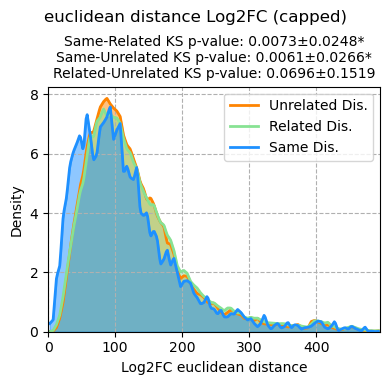

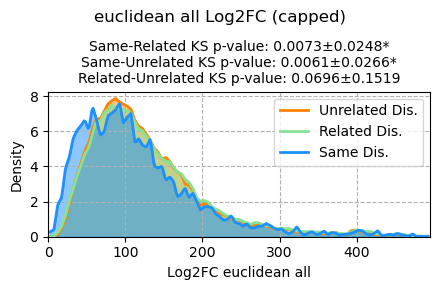

In [64]:
plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "distance"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
    figsize=(4, 4),
)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "all"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
)

2024-04-26 20:33:24,381 - INFO - Nº of values: 209 209


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


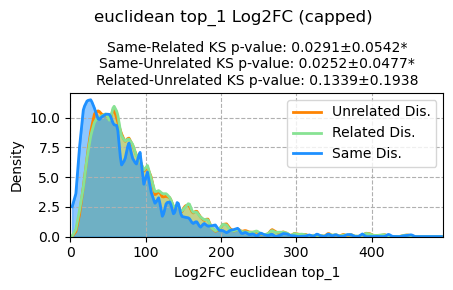

In [65]:
# pearson euclidean top_1
# define values
top_k = 1

value_1 = list()
for matrix in euclidean_values_interest_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_1.append(_matrix_values)

value_2 = list()
for matrix in euclidean_values_related_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in euclidean_values_unrelated_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Cap the values for each list
capped_value_1 = [cap_values_at_limit(v, cap_val) for v in value_1]
capped_value_2 = [cap_values_at_limit(v, cap_val) for v in value_2]
capped_value_3 = [cap_values_at_limit(v, cap_val) for v in value_3]

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_1"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
)

2024-04-26 20:34:14,547 - INFO - Nº of values: 209 209


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


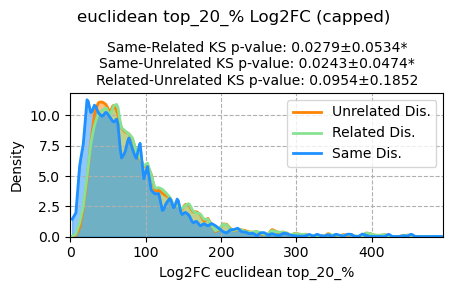

In [66]:
# pearson euclidean top_20_%
# define values
top_k = 0.2

value_1 = list()
for matrix in euclidean_values_interest_all:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in euclidean_values_related_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in euclidean_values_unrelated_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Cap the values for each list
capped_value_1 = [cap_values_at_limit(v, cap_val) for v in value_1]
capped_value_2 = [cap_values_at_limit(v, cap_val) for v in value_2]
capped_value_3 = [cap_values_at_limit(v, cap_val) for v in value_3]

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_20_%"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
)

2024-04-26 20:35:05,320 - INFO - Nº of values: 209 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


2024-04-26 20:35:08,203 - INFO - Nº of values: 209 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


2024-04-26 20:35:11,057 - INFO - Nº of values: 209 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


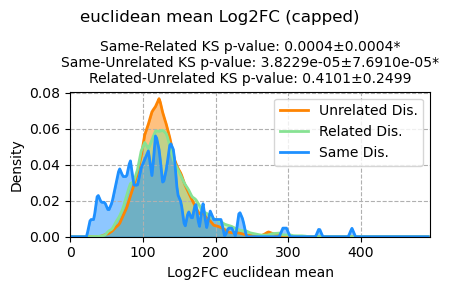

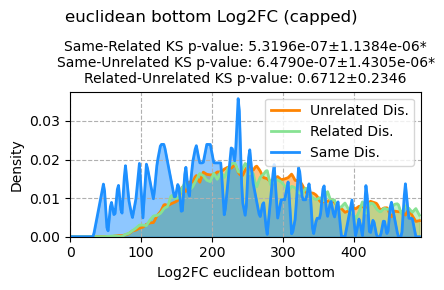

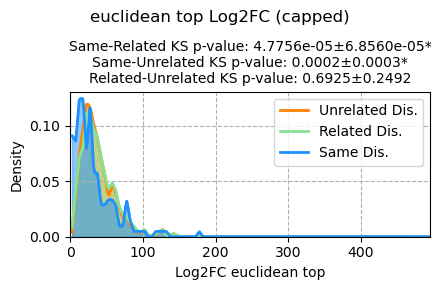

In [67]:
# pearson euclidean mean
# define values
top_k = 0.2
operation_d = {"mean": np.mean, "top": np.min, "bottom": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_1 = [operation(matrix.flatten()) for matrix in euclidean_values_interest_all]

    value_2 = [[] for _ in range(100)]
    for matrix in euclidean_values_related_all:
        n_columns = round(matrix.shape[1] / 100 * top_k)
        # iterate through rows
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in euclidean_values_unrelated_all:
        n_columns = round(matrix.shape[1] / 100 * top_k)
        # iterate through rows
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_2[i])[1])
    ks_p_values_i_r_mean, ks_p_values_i_r_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_3[i])[1])
    ks_p_values_i_u_mean, ks_p_values_i_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_2[i], value_3[i])[1])
    ks_p_values_r_u_mean, ks_p_values_r_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [flatten(value_3), flatten(value_2), value_1]
    ks_values_list = [
        [ks_p_values_i_r_mean, ks_p_values_i_r_std],
        [ks_p_values_i_u_mean, ks_p_values_i_u_std],
        [ks_p_values_r_u_mean, ks_p_values_r_u_std],
    ]

    labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["euclidean", operation_type],
        save=True,
        mesh_level=mesh_level,
        cap_value=cap_val,
        values_per_disease=False,
    )

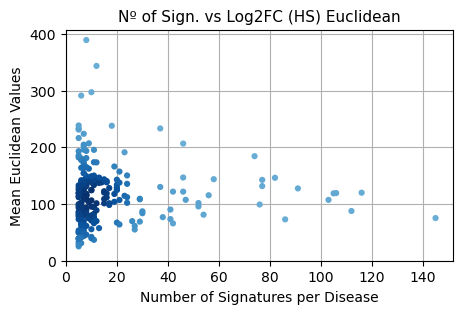

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = list()
n_signatures_per_disease = list()

for i in range(len(euclidean_values_interest_all)):
    value = np.mean(euclidean_values_interest_all[i])
    if value < cap_val:
        values_1.append(value)
        n_signatures_per_disease.append(
            len(disease_2_dsaid_filtered.get(most_common_diseases[i]))
        )


# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)

# Plot
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)

# Customization
plt.grid(True, zorder=-1)  # Add gridlines
plt.title(f"Nº of Sign. vs {metric_evaluated} ({sparsity}) Euclidean", fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Euclidean Values")
plt.xlim(
    0,
)
plt.ylim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.euclidean.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Cosine Distances

In [69]:
def get_ks_statistics_all(list_matrix_1, list_matrix_2):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_mean = np.mean(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )
    ks_p_values_std = np.std(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )

    return ks_p_values_mean, ks_p_values_std

2024-04-26 20:35:11,597 - INFO - Nº of values: 209 209


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]
cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


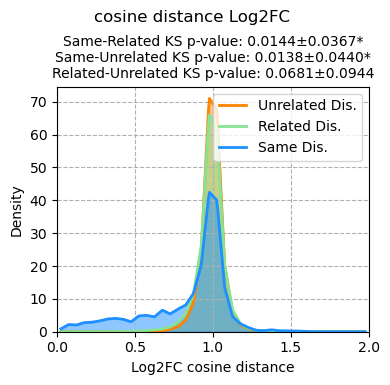

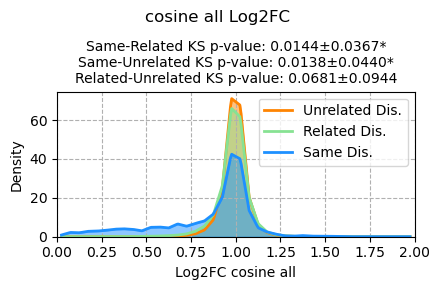

In [70]:
# plot cosine all
# get values
value_1 = cosine_values_interest_all
value_2 = cosine_values_related_all
value_3 = cosine_values_unrelated_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]


plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "distance"],
    save=True,
    mesh_level=mesh_level,
    figsize=(4, 4),
)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "all"],
    save=True,
    mesh_level=mesh_level,
)

2024-04-26 20:38:10,974 - INFO - Nº of values: 209 209


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


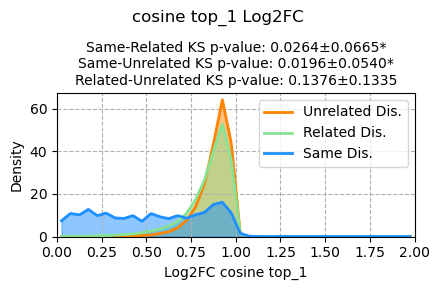

In [71]:
# plot cosine top_1
# get values
top_k = 1

value_1 = list()
for matrix in cosine_values_interest_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_1.append(_matrix_values)

value_2 = list()
for matrix in cosine_values_related_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in cosine_values_unrelated_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]


plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_1"],
    save=True,
    mesh_level=mesh_level,
)

2024-04-26 20:39:01,724 - INFO - Nº of values: 209 209
2024-04-26 20:39:01,725 - INFO - Nº of values: 209 209


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


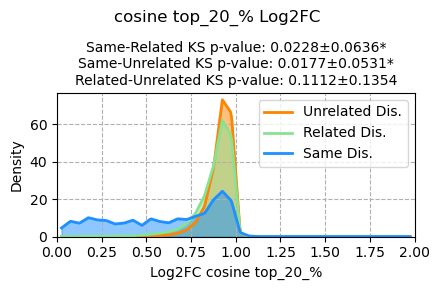

In [72]:
# plot cosine top_20_%
# get values
top_k = 0.2

value_1 = list()
for matrix in cosine_values_interest_all:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in cosine_values_related_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in cosine_values_unrelated_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]


plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_20_%"],
    save=True,
    mesh_level=mesh_level,
)

2024-04-26 20:39:42,213 - INFO - Nº of values: 209 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


2024-04-26 20:39:45,115 - INFO - Nº of values: 209 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


2024-04-26 20:39:47,985 - INFO - Nº of values: 209 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


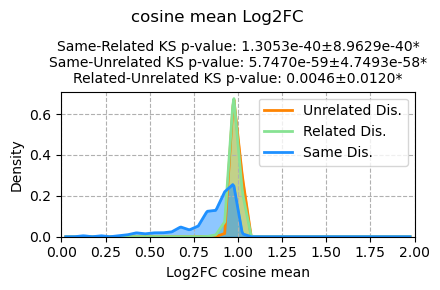

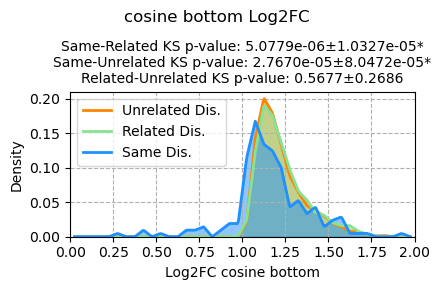

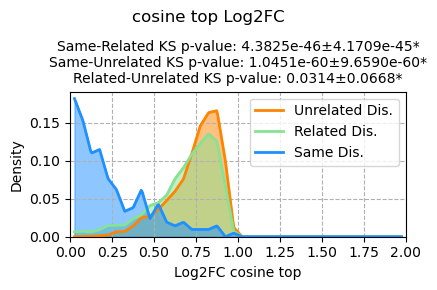

In [73]:
# pearson cosine mean
# define values
top_k = 0.2
operation_d = {"mean": np.mean, "top": np.min, "bottom": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_1 = [operation(matrix.flatten()) for matrix in cosine_values_interest_all]

    value_2 = [[] for _ in range(100)]
    for matrix in cosine_values_related_all:
        n_columns = round(matrix.shape[1] / 100 * top_k)
        # iterate through rows
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in cosine_values_unrelated_all:
        n_columns = round(matrix.shape[1] / 100 * top_k)
        # iterate through rows
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_2[i])[1])
    ks_p_values_i_r_mean, ks_p_values_i_r_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_3[i])[1])
    ks_p_values_i_u_mean, ks_p_values_i_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_2[i], value_3[i])[1])
    ks_p_values_r_u_mean, ks_p_values_r_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [flatten(value_3), flatten(value_2), value_1]
    ks_values_list = [
        [ks_p_values_i_r_mean, ks_p_values_i_r_std],
        [ks_p_values_i_u_mean, ks_p_values_i_u_std],
        [ks_p_values_r_u_mean, ks_p_values_r_u_std],
    ]

    labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["cosine", operation_type],
        save=True,
        mesh_level=mesh_level,
        values_per_disease=False,
    )

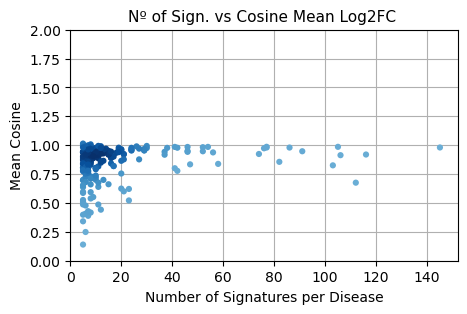

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = [np.mean(i) for i in cosine_values_interest_all]

# number of signatures per disease
n_signatures_per_disease = [
    len(disease_2_dsaid_filtered.get(disease)) for disease in most_common_diseases
]

# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)


# Plot
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)


# Customization
plt.grid(True, zorder=-1)  # Add gridlines
title_txt = f"Nº of Sign. vs Cosine Mean {metric_evaluated} "
title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
plt.title(title_txt, fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Cosine")

plt.ylim(0, 2)
plt.xlim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.cosine.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Cherry-picked diseases: tSNE & Pearson Correlations

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

single_disease_examples = [
    "Asthma",
    "Obesity",
    "Lung Adenocarcinoma",
    "Influenza",
]

colors_list = [["#4169E1", "#DC143C"],["#228B22", "#FFD700"]]

for j, disease_sublist in enumerate([
    ["Asthma", "Obesity"],
    ["Lung Adenocarcinoma", "Influenza"],
]):
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=10)


    colors = colors_list[j]
    data_matrix_copy = data_matrix.copy()

    embedded_data = tsne.fit_transform(data_matrix_copy)

    # Standardize the t-SNE embeddings (important for density calculation)
    scaler = StandardScaler()
    scaled_embedded_data = scaler.fit_transform(embedded_data)

    scaled_embedded_data = embedded_data

    # Calculate the density of points in the t-SNE space using Gaussian KDE
    bandwidth = 0.3  # Bandwidth parameter for KDE
    kde = gaussian_kde(scaled_embedded_data.T, bw_method=bandwidth)
    density = kde(scaled_embedded_data.T)

    # Create a scatter plot with colors based on local density
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        embedded_data[:, 0],
        embedded_data[:, 1],
        c=density,
        cmap="grey",
        s=25,
        edgecolor="none",
    )

    # specific indexes
    d_disease_2_index = dict()
    for i, disease in enumerate(disease_sublist):
        # dsaids w/ diseases of interest
        dsaids_interest = disease_2_dsaid_filtered.get(disease)

        # Extract the specific vectors using the list of indexes
        interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

        plt.scatter(
            embedded_data[interest_idxs, 0],
            embedded_data[interest_idxs, 1],
            color=colors[i],
            label=f"{disease}({len(interest_idxs)})",
            s=20,
            alpha=0.8,
        )

    plt.legend()
    # plt.colorbar(scatter, label="Local Density")
    plt.title(f"t-SNE {metric_evaluated} ({sparsity}) Signatures")
    # plt.xlabel("t-SNE Dimension 1")
    # plt.ylabel("t-SNE Dimension 2")
    plt.xticks([])
    plt.yticks([])

    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"tsne.{sparsity}.{j}.{metric_evaluated}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [159]:
for j, disease_sublist in [
    ["Asthma", "Obesity"],
    ["Lung Adenocarcinoma", "Influenza"],
]:

    print(disease_sublist)

Obesity
Influenza


In [158]:
disease_sublist

'Obesity'

In [153]:
disease_2_dsaid_filtered.get(disease)

In [156]:
print(disease)

O


/tmp/ipykernel_117776/2741086909.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(data, method="average")


/tmp/ipykernel_117776/2741086909.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(data, method="average")
/tmp/ipykernel_117776/2741086909.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(data, method="average")
/tmp/ipykernel_117776/2741086909.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(data, method="average")


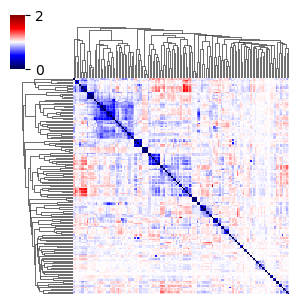

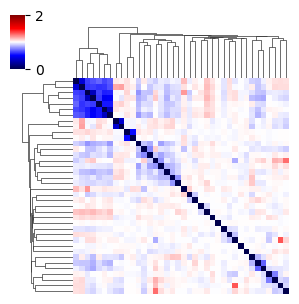

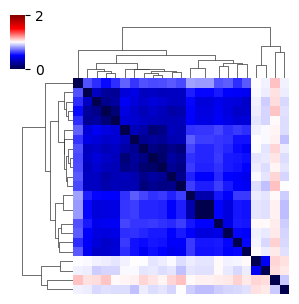

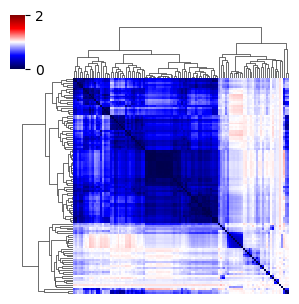

In [142]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris

# sns.set(font="monospace")
for i, disease in enumerate(single_disease_examples):
    # dsaids w/ diseases of interest
    dsaids_interest = disease_2_dsaid_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])
    data = matrix_cosine_distance[interest_idxs][:, interest_idxs]
    linkage = hc.linkage(data, method="average")

    # Create a cluster map
    g = sns.clustermap(
        data,
        row_linkage=linkage,
        col_linkage=linkage,
        cmap="seismic",
        vmin=0,  # Minimum value of the colormap
        vmax=2,  # Maximum value of the colormap
        figsize=(3, 3),
        row_cluster=True,  # Disable clustering for rows
        xticklabels=False,  # Remove x-axis tick labels
        yticklabels=False,  # Remove y-axis tick labels
        # dendrogram_ratio=(0, 0)  # Set dendrogram size to zero for both rows and columns
    )
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"cluster.{disease}.{metric_evaluated}.mesh.{sparsity}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [113]:
for i, disease in enumerate(single_disease_examples):
    # query
    QUERY = f"disease == @disease"
    dsaids = df_matrix.query(QUERY)["dsaid"].to_list()

    print(dsaids)

[]
['DSA00630', 'DSA00782', 'DSA00800', 'DSA00963', 'DSA01075', 'DSA01076', 'DSA01269', 'DSA01335', 'DSA01762', 'DSA02366', 'DSA02513', 'DSA02924', 'DSA02925', 'DSA03085', 'DSA03174', 'DSA03229', 'DSA03230', 'DSA03360', 'DSA03940', 'DSA04688', 'DSA04856', 'DSA04901', 'DSA04975', 'DSA05185', 'DSA05186', 'DSA06337', 'DSA06338', 'DSA06992', 'DSA07041', 'DSA07042', 'DSA07327', 'DSA07474', 'DSA08229', 'DSA08472', 'DSA09371', 'DSA09559', 'DSA09881', 'DSA10194']
['DSA00042', 'DSA00328', 'DSA00374', 'DSA01381', 'DSA04133', 'DSA07436', 'DSA07500', 'DSA07501', 'DSA08067', 'DSA08068', 'DSA08970', 'DSA08971', 'DSA08972', 'DSA09446', 'DSA09501', 'DSA09539', 'DSA09986', 'DSA10221', 'DSA10246', 'DSA10252', 'DSA10257', 'DSA10258', 'DSA10289']
['DSA00232', 'DSA00281', 'DSA01761', 'DSA01932', 'DSA01999', 'DSA05889', 'DSA05890', 'DSA05891', 'DSA05892', 'DSA06677', 'DSA06723', 'DSA06724', 'DSA06725', 'DSA06794', 'DSA06799', 'DSA06925', 'DSA07031', 'DSA07032', 'DSA07052', 'DSA07100', 'DSA08115', 'DSA08116'

In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    average_precision_score,
)
import numpy as np


def get_k_precision(idxs, k, matrix):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs: list of indexes
        k: int
        matrix: np.array
    Returns:
        np.array
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    return np.sum(labels[idx_k], axis=1) / 3


def get_k_precision(idxs, k, matrix, top=True):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs (list): indexes
        k (int): k values
        matrix (np.array): matrix of similarities
        top (bool): get top k or bottom k
    Returns:
        np.array: precision values
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    if top:
        idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    else:
        idx_k = np.argpartition(matrix[idxs], k, axis=1)[:, :k]
    return list(np.sum(labels[idx_k], axis=1))


# Example AUROC calculation using kNN for each disease signature
auroc_scores = {"correlation": [], "cosine": [], "euclidean": [], "disease": []}
auroc_scores = {"correlation": [], "disease": []}

# Assuming `data_matrix` is your feature matrix where rows are disease signatures
num_diseases = len(most_common_diseases)

copy_matrix_pearson_correlation = np.copy(matrix_pearson_correlation)
np.fill_diagonal(copy_matrix_pearson_correlation, 0)

copy_matrix_cosine_distance = np.copy(matrix_cosine_distance)
np.fill_diagonal(copy_matrix_cosine_distance, 1)

copy_matrix_euclidean_distance = np.copy(matrix_euclidean_distance)
np.fill_diagonal(copy_matrix_euclidean_distance, np.inf)


correlation_tp_dict = dict()
cosine_tp_dict = dict()
euclidean_tp_dict = dict()

for idx, disease in tqdm(enumerate(single_disease_examples)):

    # dsaids w/ diseases of interest
    QUERY = f"disease == @disease"
    df_query = df_matrix.query(QUERY)
    dsaids_interest = df_query["dsaid"].to_list()
    interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

    correlation_tp_dict[disease] = get_k_precision(
        interest_idxs, 3, copy_matrix_pearson_correlation
    )

    cosine_tp_dict[disease] = get_k_precision(
        interest_idxs, 3, copy_matrix_cosine_distance, top=False
    )

    euclidean_tp_dict[disease] = get_k_precision(
        interest_idxs, 3, copy_matrix_euclidean_distance, top=False
    )

del (
    copy_matrix_pearson_correlation,
    copy_matrix_cosine_distance,
    copy_matrix_euclidean_distance,
)

4it [00:00, 72.55it/s]


In [139]:
for x in correlation_tp_dict.values():
    print(np.mean(x))

1.7862068965517242
0.7105263157894737
1.9130434782608696
2.732142857142857


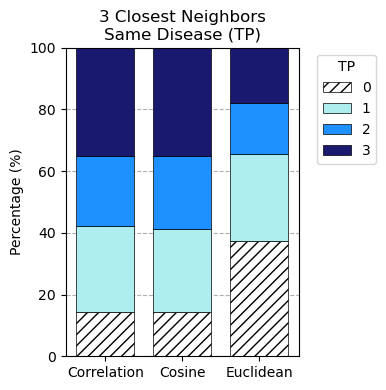

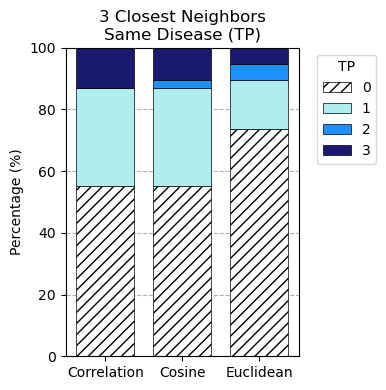

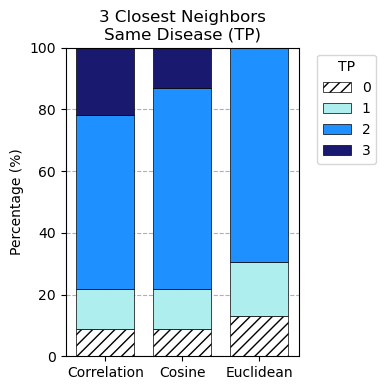

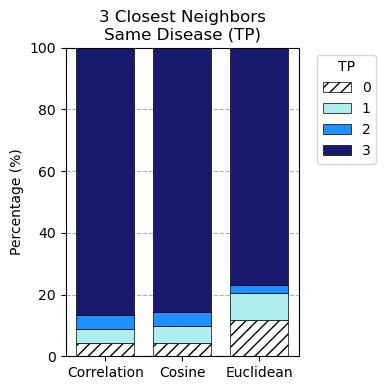

In [141]:
import numpy as np
import matplotlib.pyplot as plt

for disease in single_disease_examples:

    # Simulated data for each metric (assuming integers 0, 1, 2, 3 represent the count of nearest neighbors that are the same disease)
    data_1 = correlation_tp_dict.get(disease)  # Correlation
    data_2 = cosine_tp_dict.get(disease)  # Cosine
    data_3 = euclidean_tp_dict.get(disease)  # Euclidean

    # Bin edges for the categories
    bins = np.array([0, 1, 2, 3, 4])

    # define colors
    colors = ["white", "paleturquoise", "#1E90FF", "midnightblue"]

    # Calculate histogram data for each
    counts_1, _ = np.histogram(data_1, bins=bins)
    counts_2, _ = np.histogram(data_2, bins=bins)
    counts_3, _ = np.histogram(data_3, bins=bins)

    # Labels for the plot
    metrics_labels = ["Correlation", "Cosine", "Euclidean"]
    category_labels = [f"{i}" for i in range(4)]  # Labels for the legend

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(4, 4))

    # Width of each stack segment
    width = 0.75

    # Convert counts to percentage
    percentage_1 = counts_1 / len(data_1) * 100
    percentage_2 = counts_2 / len(data_2) * 100
    percentage_3 = counts_3 / len(data_3) * 100

    # Stack the bars for each metric
    for i, counts in enumerate([percentage_1, percentage_2, percentage_3]):
        bottom_shift = np.cumsum([0] + counts.tolist())[
            :-1
        ]  # Calculate the bottom position for each stack
        for j in range(len(counts)):

            if j == 0:
                ax.bar(
                    metrics_labels[i],
                    counts[j],
                    bottom=bottom_shift[j],
                    width=width,
                    label=f"{category_labels[j]}" if i == 0 else "",
                    color=colors[j],
                    zorder=2,
                    edgecolor="black",
                    linewidth=0.5,
                    hatch="///",
                )
            else:
                ax.bar(
                    metrics_labels[i],
                    counts[j],
                    bottom=bottom_shift[j],
                    width=width,
                    label=f"{category_labels[j]}" if i == 0 else "",
                    color=colors[j],
                    zorder=2,
                    edgecolor="black",
                    linewidth=0.5,
                )

    # Add a legend and axis labels
    ax.set_ylabel("Percentage (%)")
    ax.set_title("3 Closest Neighbors\nSame Disease (TP)")
    ax.legend(title="TP", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.ylim(0, 100)
    # Show the plot
    plt.grid(linestyle="--", zorder=-3)
    plt.tight_layout()

    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"nn.{disease}.{metric_evaluated}.mesh.{sparsity}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

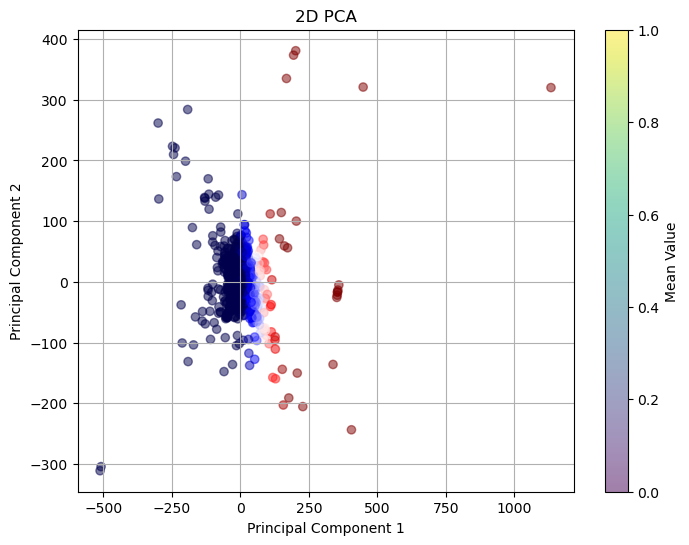

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_components = 64

# Create a colormap instance
cmap = plt.get_cmap("seismic")

# Standardize the dataset
scaler = StandardScaler()
data_matrix_standardized = scaler.fit_transform(data_matrix)

data_matrix_copy = data_matrix.copy()
data_matrix_standardized = data_matrix_copy
# Calculate the mean of each data point in the original data
means = np.mean(data_matrix_copy, axis=1)

# Perform PCA
pca = PCA(
    n_components=n_components
)  # Use 3 components for 3D visualization and explained variance plot
pca_result = pca.fit_transform(data_matrix_standardized)

# 2D PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=cmap(means))
plt.title("2D PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Mean Value")  # Show color scale
plt.grid(True)
plt.show()

In [77]:
dsaids_matrix[np.argmax(pca_result[:, 0])]

'DSA04473'

In [78]:
np.argmax(pca_result[:, 0])

2268

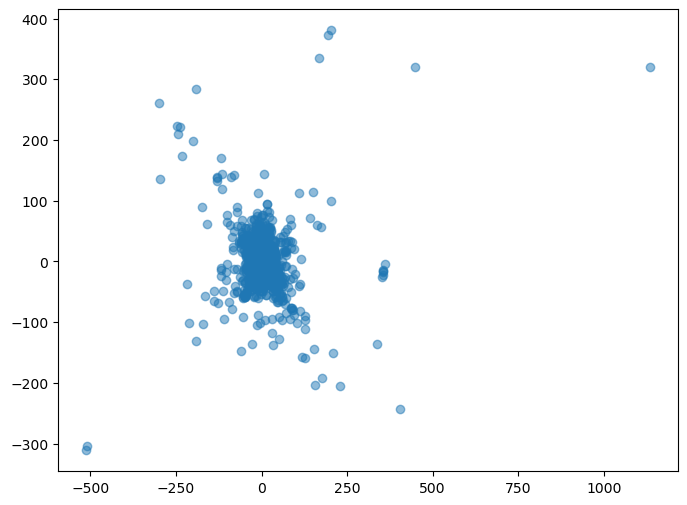

In [79]:
pca = PCA(
    n_components=n_components
)  # Use 3 components for 3D visualization and explained variance plot
pca_result = pca.fit_transform(data_matrix)

# 2D PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

In [80]:
pca.explained_variance_ratio_

array([0.10163169, 0.05571772, 0.03230211, 0.02348463, 0.01821993,
       0.01685241, 0.01526312, 0.01459585, 0.01293025, 0.0111033 ,
       0.01029866, 0.00965979, 0.0086013 , 0.00740385, 0.00722668,
       0.00701825, 0.00685883, 0.0061105 , 0.0058645 , 0.00555295,
       0.00520956, 0.00497205, 0.00484427, 0.00470921, 0.00464385,
       0.00434658, 0.00423783, 0.00413097, 0.00391833, 0.00369374,
       0.0035879 , 0.00354506, 0.00341755, 0.00339493, 0.00336923,
       0.00324842, 0.00316507, 0.00306296, 0.00299494, 0.00298009,
       0.00291723, 0.00287735, 0.00277617, 0.00273905, 0.00258536,
       0.00255065, 0.0025275 , 0.00247838, 0.00242195, 0.00236868,
       0.00233301, 0.00231555, 0.00224537, 0.00222916, 0.00217088,
       0.00211582, 0.00208689, 0.0020542 , 0.00201589, 0.00198401,
       0.00196346, 0.00193159, 0.001907  , 0.00186695])

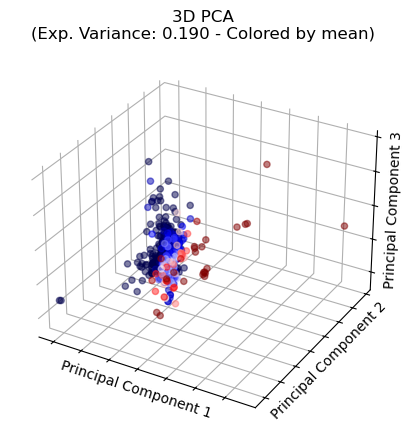

In [81]:
# Create 3D PCA plot
fig = plt.figure(figsize=(7, 5))  # Increased figure size
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    pca_result[:, 2],
    alpha=0.5,
    c=cmap(means),
)

# Remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Set edge color to white
ax.xaxis.pane.set_edgecolor("w")
ax.yaxis.pane.set_edgecolor("w")
ax.zaxis.pane.set_edgecolor("w")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)

# Set labels
ax.set_xlabel("Principal Component 1", labelpad=-12)
ax.set_ylabel("Principal Component 2", labelpad=-12)
ax.set_zlabel("Principal Component 3", labelpad=-12)
ax.set_title(
    "3D PCA\n(Exp. Variance: %.3f - Colored by mean)"
    % pca.explained_variance_ratio_[:3].sum()
)
ax.tick_params(axis="z", pad=-3)


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pca.3d_pca_{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

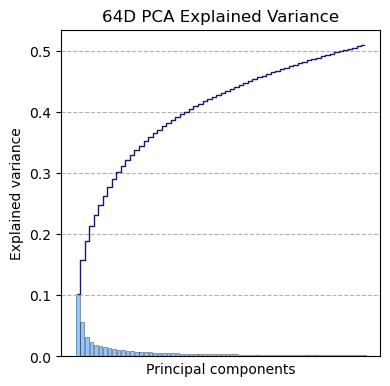

In [82]:
# Explained variance plot
plt.figure(figsize=(4, 4))
plt.bar(
    range(1, n_components + 1),  # Adjust range to match the number of components
    pca.explained_variance_ratio_,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
    color="#1E90FF",
    edgecolor="black",
    linewidth=0.5,
)
plt.step(
    range(1, n_components + 1),  # Adjust range
    np.cumsum(pca.explained_variance_ratio_),
    where="mid",
    label="Cumulative",
    color="midnightblue",
    linewidth=1,
)
plt.ylabel("Explained variance")
plt.xlabel("Principal components")
# plt.legend(loc="best")
plt.tight_layout()
plt.xticks([])  # Ensure x-ticks for all components
plt.title("64D PCA Explained Variance")

plt.grid(True, zorder=-3, linestyle="--")
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pca.variance_{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

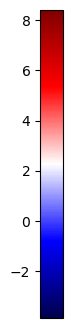

In [83]:
# Create a figure for the color bar
fig, ax = plt.subplots(figsize=(0.3, 4))

# Create a scalar mappable for the color bar
norm = mpl.colors.Normalize(vmin=np.min(means), vmax=np.max(means))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can safely ignore this line as it's just to avoid warnings

# Create the color bar
cbar = plt.colorbar(sm, cax=ax)

# Move color bar tick labels and lines to the left
cbar.ax.yaxis.set_ticks_position("left")  # This moves tick lines to the left
cbar.ax.yaxis.set_label_position(
    "left"
)  # This ensures the label is aligned with the ticks
cbar.ax.yaxis.set_tick_params(
    labelleft=True, labelright=False
)  # Adjusts labels to the left

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pca.cbar_{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

100%|██████████| 4/4 [00:18<00:00,  4.62s/it]


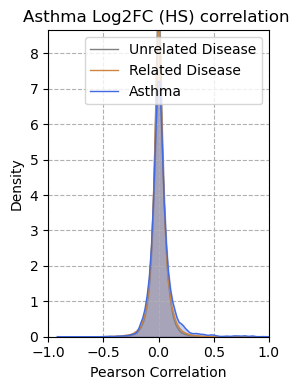

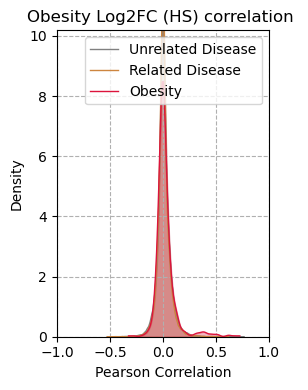

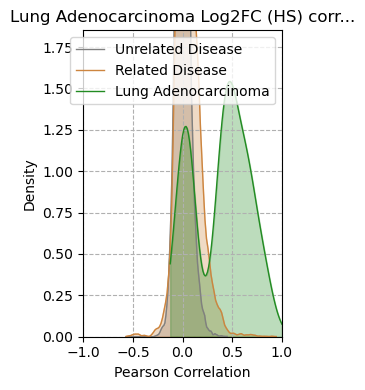

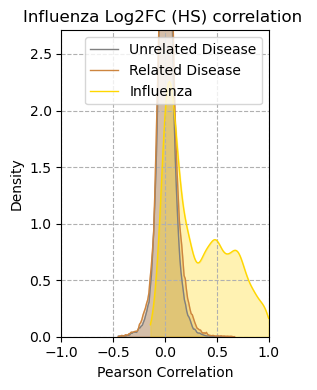

In [166]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

single_disease_examples = [
    "Asthma",
    "Obesity",
    "Lung Adenocarcinoma",
    "Influenza",
]

# colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]
colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# get index for diseases of interest

for i, disease in enumerate(tqdm(single_disease_examples)):
    # get index of the disease
    disease_index = most_common_diseases.index(disease)

    value_1 = correlation_values_interest_all[disease_index].flatten()
    value_2 = correlation_values_related_all[disease_index].flatten()
    value_3 = correlation_values_unrelated_all[disease_index].flatten()

    # Plot setup
    plt.figure(figsize=(3, 4))

    # Plot distribution for value_3
    density_3 = stats.gaussian_kde(value_3)
    x_3 = np.linspace(min(value_2), max(value_3), 100)
    plt.plot(x_3, density_3(x_3), linewidth=1, label="Unrelated Disease", color="grey")
    plt.fill_between(x_3, density_3(x_3), alpha=0.3, color="grey")

    # Plot distribution for value_2
    density_2 = stats.gaussian_kde(value_2)
    x_2 = np.linspace(min(value_2), max(value_2), 100)
    plt.plot(x_2, density_2(x_2), linewidth=1, label="Related Disease", color="peru")
    plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="peru")

    # Plot distribution for value_1
    density_1 = stats.gaussian_kde(value_1)
    x_1 = np.linspace(min(value_1), max(value_1), 100)
    plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
    plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

    # Finalizing plot
    title_example = f"{disease} {metric_evaluated} ({sparsity}) correlation "
    title_example = (
        title_example[:36] + "..." if len(title_example) > 40 else title_example
    )

    plt.title(title_example)
    plt.legend()
    plt.xlabel("Pearson Correlation")
    plt.xlim(-1, 1)
    plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"distribution.mesh.diseases_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [147]:
df_matrix[df_matrix["disease"] == "Asthma"]

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition
72,DSA00073,GSE206510,GPL16791,2,Asthma,C0004096,NaN,GEO,RNA-Seq,Homo sapiens,5|5,DO:A bronchial disease that is characterized b...
73,DSA00074,GSE206510,GPL16791,1,Asthma,C0004096,NaN,GEO,RNA-Seq,Homo sapiens,4|5,DO:A bronchial disease that is characterized b...
246,DSA00247,GSE100624,GPL17303,1000,Asthma,C0004096,Peripheral blood,GEO,RNA-Seq,Homo sapiens,1|3,DO:A bronchial disease that is characterized b...
247,DSA00248,GSE100624,GPL17303,1000,Asthma,C0004096,Peripheral blood,GEO,RNA-Seq,Homo sapiens,1|3,DO:A bronchial disease that is characterized b...
248,DSA00249,GSE100624,GPL17303,1000,Asthma,C0004096,Peripheral blood,GEO,RNA-Seq,Homo sapiens,1|3,DO:A bronchial disease that is characterized b...
...,...,...,...,...,...,...,...,...,...,...,...,...
8868,DSA08869,GSE144576,GPL20301,954,Asthma,C0004096,NaN,GEO,RNA-Seq,Homo sapiens,8|8,DO:A bronchial disease that is characterized b...
9400,DSA09401,GSE147878,GPL10558,116,Asthma,C0004096,Bronchus,GEO,Microarray,Homo sapiens,13|18,DO:A bronchial disease that is characterized b...
9401,DSA09402,GSE147880,GPL6104,0,Asthma,C0004096,Sputum,GEO,Microarray,Homo sapiens,18|8,DO:A bronchial disease that is characterized b...
9411,DSA09412,GSE148004,GPL13497,0,Asthma,C0004096,Sputum,GEO,Microarray,Homo sapiens,9|9,DO:A bronchial disease that is characterized b...


In [85]:
# # Corrected function name and variable names for clarity
# def get_top_k_library_strategies(disease, k=2, df_matrix=df_matrix):
#     """Get Top K Library Strategies for a specific disease
#     Args:
#         disease (str): disease of interest
#         k (int): top k most common values
#         df_matrix (DataFrame): DataFrame containing the data
#     Returns:
#         list: list of k most common library strategies
#     """
#     # Filter DataFrame for the specified disease
#     df_filtered = df_matrix[df_matrix["disease"] == disease]

#     # Get the top k library strategies
#     top_k_strategies = df_filtered["library_strategy"].value_counts().head(k).index

#     # Initialize list to store lists of DSAIDs for each library strategy
#     dsaids_per_strategy = []

#     # Iterate through top k library strategies and collect corresponding DSAIDs
#     for strategy in top_k_strategies:
#         dsaids = df_filtered[df_filtered["library_strategy"] == strategy][
#             "dsaid"
#         ].tolist()
#         dsaids_per_strategy.append(dsaids)

#     return (top_k_strategies.tolist(), dsaids_per_strategy)


# def get_top_k_tissues(disease, k=4, df_matrix=df_matrix):
#     """Get Top K Tissues for a specific disease
#     Args:
#         disease (str): disease of interest
#         k (int): top k most common values
#     Returns
#         tissues (list): list of k most common tissues
#     """
#     # Filter DataFrame for the specified disease
#     df_filtered = df_matrix[df_matrix["disease"] == disease]

#     # Get the top k library strategies
#     top_k_strategies = df_filtered["tissue"].value_counts().head(k).index

#     # Initialize list to store lists of DSAIDs for each library strategy
#     dsaids_per_strategy = []

#     # Iterate through top k library strategies and collect corresponding DSAIDs
#     for strategy in top_k_strategies:
#         dsaids = df_filtered[df_filtered["tissue"] == strategy]["dsaid"].tolist()
#         dsaids_per_strategy.append(dsaids)

#     return (top_k_strategies.tolist(), dsaids_per_strategy)


# # Assuming 'df_data_info_processed_filtered' is your DataFrame and you want to find top 4 library strategies for "Covid-19"
# top_k_library_strategies, dsaids_library_stratergies = get_top_k_library_strategies(
#     "COVID-19", 2, df_matrix
# )
# print(top_k_library_strategies)

# top_k_tissues, dsaids_tissues = get_top_k_tissues("COVID-19", 6, df_matrix)
# print(top_k_tissues)

# top_k_accessions, dsaids_accessions = get_top_k_accessions("COVID-19", 4, df_matrix)
# print(top_k_accessions)

In [86]:
# def get_top_k(disease, field, k=4, df_matrix=df_matrix):
#     """Get Top K Tissues for a specific disease
#     Args:
#         disease (str): disease of interest
#         k (int): top k most common values
#     Returns
#         tissues (list): list of k most common tissues
#     """
#     # Filter DataFrame for the specified disease
#     df_filtered = df_matrix[df_matrix["disease"] == disease]

#     # Get the top k library strategies
#     top_k = df_filtered[field].value_counts().head(k).index

#     # Initialize list to store lists of DSAIDs for each library strategy
#     dsaids_interest = []

#     # Iterate through top k library strategies and collect corresponding DSAIDs
#     for strategy in top_k:
#         dsaids = df_filtered[df_filtered[field] == strategy]["dsaid"].tolist()
#         dsaids_interest.append(dsaids)

#     return (top_k.tolist(), dsaids_interest)

In [87]:
# df_matrix[df_matrix["disease"] == "COVID-19"]["library_strategy"].value_counts()

In [88]:
# top_k, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

In [89]:
# # Tissue Bias
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
# from scipy.stats import gaussian_kde

# disease = "COVID-19"
# k = 4
# field = "accession"
# colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# plt.figure(figsize=(8, 8))
# scatter = plt.scatter(
#     embedded_data[:, 0],
#     embedded_data[:, 1],
#     c=density,
#     cmap="grey",
#     s=20,
#     edgecolor="none",
#     alpha=0.8,
# )


# # get specific tissues for disease
# top_ks, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

# for i, top_k in enumerate(top_ks):
#     # dsaids for specific tissue
#     dsaids_interest = top_k_dsaids[i]

#     # Extract the specific vectors using the list of indexes
#     interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

#     if field == "accession":
#         label_text = f"{disease}: Dataset {i+1} ({len(interest_idxs)})"

#     else:
#         label_text = f"{disease}: {top_k}"

#     plt.scatter(
#         embedded_data[interest_idxs, 0],
#         embedded_data[interest_idxs, 1],
#         color=colors[i],
#         label=label_text,
#         s=40,
#         alpha=0.8,
#     )

# plt.legend()
# # plt.colorbar(scatter, label="Local Density")
# plt.title(f"t-SNE {disease} {field} ( {metric_evaluated} {sparsity} Signatures )")
# # plt.xlabel("t-SNE Dimension 1")
# # plt.ylabel("t-SNE Dimension 2")
# plt.xticks([])
# plt.yticks([])

# plt.savefig(
#     os.path.join(
#         "..",
#         "results",
#         "figures",
#         "DiSignAtlas",
#         f"tsne.{disease}.{field}.{sparsity}.{metric_evaluated}.png",
#     ),
#     dpi=300,
#     bbox_inches="tight",
# )

In [90]:
# # Plot distribution of means

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats

# disease = "COVID-19"
# k = 4
# field = "accession"
# colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# # get specific tissues for disease
# top_ks, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

# for i, top_k in enumerate(top_ks):
#     # dsaids for specific tissue
#     dsaids_interest = top_k_dsaids[i]

#     # Extract the specific vectors using the list of indexes
#     interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

#     # random indexes withtout replacement - appear once
#     random_rest_indexes = get_rest_indexes(
#         interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
#     )

#     # matrix interest
#     matrix_interest = data_matrix[interest_idxs]

#     # matrix rest
#     matrix_rest = data_matrix[random_rest_indexes]

#     # compute correlation
#     correlation_values_interest = compute_pearson_correlation(matrix_interest)
#     correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

#     value_1 = correlation_values_interest
#     value_2 = correlation_values_rest

#     # Plot setup
#     plt.figure(figsize=(4, 4))

#     # Plot distribution for value_1
#     density_1 = stats.gaussian_kde(value_1)
#     x_1 = np.linspace(min(value_1), max(value_1), 100)
#     plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
#     plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

#     # Plot distribution for value_2
#     density_2 = stats.gaussian_kde(value_2)
#     x_2 = np.linspace(min(value_2), max(value_2), 100)
#     plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
#     plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

#     # Finalizing plot
#     if field == "accession":
#         title_example = (
#             f"{disease} Dataset {i+1} {metric_evaluated} ({sparsity}) correlation"
#         )
#     else:
#         title_example = (
#             f"{disease} {top_k} {metric_evaluated} ({sparsity}) correlation "
#         )

#     title_example = (
#         title_example[:36] + "..." if len(title_example) > 40 else title_example
#     )

#     plt.title(title_example)
#     plt.legend()
#     plt.xlabel("Pearson Correlation")
#     plt.xlim(-1, 1)
#     plt.ylim(0, max(density_1(x_1)) * 1.2)
#     plt.ylabel("Density")
#     plt.grid(linestyle="--")
#     plt.tight_layout()

#     # save
#     plt.savefig(
#         os.path.join(
#             "..",
#             "results",
#             "figures",
#             "DiSignAtlas",
#             f"distribution.diseases_correlation.{disease}.{field}.{i}.{sparsity}.{metric_evaluated}.{disease}.png",
#         ),
#         dpi=300,
#         bbox_inches="tight",
#     )

In [91]:
# # Plot distribution of means

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats

# single_disease_examples = [
#     "Colon Cancer",
# ]

# colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# for i, disease in enumerate(tqdm(single_disease_examples)):

#     # dsaids w/ diseases of interest
#     dsaids_interest = disease_2_dsaid_filtered.get(disease)

#     # Extract the specific vectors using the list of indexes
#     interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

#     # random indexes withtout replacement - appear once
#     random_rest_indexes = get_rest_indexes(
#         interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
#     )

#     # matrix interest
#     matrix_interest = data_matrix[interest_idxs]

#     # matrix rest
#     matrix_rest = data_matrix[random_rest_indexes]

#     # compute correlation
#     correlation_values_interest = compute_pearson_correlation(matrix_interest)
#     correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

#     value_1 = correlation_values_interest
#     value_2 = correlation_values_rest

#     # Plot setup
#     plt.figure(figsize=(4, 4))

#     # Plot distribution for value_1
#     density_1 = stats.gaussian_kde(value_1)
#     x_1 = np.linspace(min(value_1), max(value_1), 100)
#     plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
#     plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

#     # Plot distribution for value_2
#     density_2 = stats.gaussian_kde(value_2)
#     x_2 = np.linspace(min(value_2), max(value_2), 100)
#     plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
#     plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

#     # Finalizing plot
#     title_example = f"{disease} {metric_evaluated} ({sparsity}) correlation "
#     title_example = (
#         title_example[:36] + "..." if len(title_example) > 40 else title_example
#     )

#     plt.title(title_example)
#     plt.legend()
#     plt.xlabel("Pearson Correlation")
#     plt.xlim(-1, 1)
#     plt.ylim(0, max(density_1(x_1)) * 1.2)
#     plt.ylabel("Density")
#     plt.grid(linestyle="--")
#     plt.tight_layout()

#     # save
#     plt.savefig(
#         os.path.join(
#             "..",
#             "results",
#             "figures",
#             "DiSignAtlas",
#             f"distribution.diseases_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
#         ),
#         dpi=300,
#         bbox_inches="tight",
#     )

### Plots MeSH Terms

#### Get diseases of interest

In [92]:
# get diseases for the lowest mesh level we will compare ! ! !
# variables
lowest_mesh_level = 5
count_diseases_per_level = dict()
for level in [1, 2, 3, 4, 5]:
    diseases_of_interest = list()
    for count, disease in enumerate(tqdm(most_common_diseases)):

        # dsaids w/ diseases of interest
        QUERY = f"disease == @disease"
        df_query = df_matrix.query(QUERY)
        dsaids_interest = df_query["dsaid"].to_list()

        # get mesh terms
        _dsaids_interest_mesh_terms = list(
            {
                mesh_term
                for d in dsaids_interest
                for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
            }
        )

        if check_mesh_level(_dsaids_interest_mesh_terms, level=level):

            # get ids of rest
            _rest_dsaids = list(set(dsaids_matrix) - set(dsaids_interest))

            related_dsaids = list()
            unrelated_dsaids = list()

            # classify rest of ids into related or unrelated
            for dsaid in _rest_dsaids:
                dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
                dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
                # check if they are related
                if check_common_mesh_terms(
                    list_1=_dsaids_interest_mesh_terms,
                    list_2=dsaid_mesh_terms,
                    level=level,
                ):
                    related_dsaids.append(dsaid)

                else:
                    unrelated_dsaids.append(dsaid)

            if len(related_dsaids) > 10:
                diseases_of_interest.append(disease)

    count_diseases_per_level[level] = len(diseases_of_interest)
logging.info(f"Nº of diseases {len(diseases_of_interest)}")

100%|██████████| 209/209 [00:02<00:00, 104.18it/s]
2024-04-26 20:40:27,784 - INFO - Nº of diseases 62


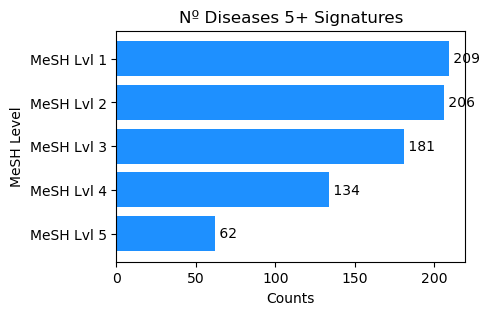

In [93]:
def plot_horizontal_bar(data):
    # Extract keys and values from the dictionary
    labels = [f"MeSH Lvl {key}" for key in [5, 4, 3, 2, 1]]
    values = [data.get(key) for key in [5, 4, 3, 2, 1]]

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(4.5, 3))

    # Plot horizontal bar plot
    ax.barh(labels, values, color="#1E90FF")  # You can change the color if needed

    # Set title and labels
    ax.set_title("Nº Diseases 5+ Signatures")
    ax.set_xlabel("Counts")
    ax.set_ylabel("MeSH Level")

    # Optional: Add value labels on bars
    for index, value in enumerate(values):
        ax.text(value, index, f" {value}", va="center", ha="left")

    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"counts_diseases.mesh_all.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )


plot_horizontal_bar(data=count_diseases_per_level)

In [94]:
count_diseases_per_level

{1: 209, 2: 206, 3: 181, 4: 134, 5: 62}

#### Compute Similarities

In [95]:
d_mesh_correlation = dict()
d_mesh_cosine = dict()
d_mesh_euclidean = dict()

# variables
k_top = 1
k_percent = 0.2
mesh_level = 5
bootstrap = True
n_diseases = 0

d_n_signatures = dict()


for mesh_level in [1, 2, 3, 4, 5]:

    d_n_signatures[mesh_level] = dict()
    d_n_signatures[mesh_level]["interest"] = list()
    d_n_signatures[mesh_level]["related"] = list()

    correlation_values_interest_all = list()
    correlation_values_related_all = list()
    correlation_values_unrelated_all = list()

    cosine_values_interest_all = list()
    cosine_values_related_all = list()
    cosine_values_unrelated_all = list()

    euclidean_values_interest_all = list()
    euclidean_values_related_all = list()
    euclidean_values_unrelated_all = list()

    # get values
    all_indexes = set(range(data_matrix.shape[0]))

    for count, disease in enumerate(tqdm(diseases_of_interest)):

        # dsaids w/ diseases of interest
        QUERY = f"disease == @disease"
        df_query = df_matrix.query(QUERY)
        dsaids_interest = df_query["dsaid"].to_list()

        d_n_signatures[mesh_level]["interest"].append(len(dsaids_interest))
        related_dsaids = list()
        unrelated_dsaids = list()

        # get mesh terms
        _dsaids_interest_mesh_terms = list(
            {
                mesh_term
                for d in dsaids_interest
                for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
            }
        )

        if check_mesh_level(_dsaids_interest_mesh_terms, level=mesh_level):

            # Extract the specific vectors using the list of indexes
            interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

            # interest indexes pairs
            """We have a list of lists in which we have
            for each disease signature of interest (row of a matrix) a list in which 
            we will have all the combination of pairs"""

            n_interest = len(interest_idxs)

            # compute how many pairs we will have
            n_interest_unique = int(n_interest * (n_interest - 1) / 2)
            n_interest_all = int(n_interest * n_interest)

            interest_idxs_pairs = np.empty((n_interest, n_interest - 1, 2), dtype=int)
            interest_idxs_pairs_unique = np.empty((n_interest_unique, 2), dtype=int)

            # generate pairs (all vs all)
            matrix_interest_idxs_pairs = generate_matrix_idxs(
                interest_idxs, bootstrap=False
            )

            # define matrix to store values
            matrix_correlation_values_interest = np.empty(
                (n_interest, n_interest - 1), dtype=float
            )

            matrix_cosine_values_interest = np.empty(
                (n_interest, n_interest - 1), dtype=float
            )

            matrix_euclidean_values_interest = np.empty(
                (n_interest, n_interest - 1), dtype=float
            )

            # itereate through all interest signatures
            for i, row_interest in enumerate(matrix_interest_idxs_pairs):
                # get values
                correlation_values_interest = matrix_pearson_correlation[
                    row_interest[:, 0], row_interest[:, 1]
                ]
                cosine_values_interest = matrix_cosine_distance[
                    row_interest[:, 0], row_interest[:, 1]
                ]
                euclidean_values_interest = matrix_euclidean_distance[
                    row_interest[:, 0], row_interest[:, 1]
                ]

                # store values
                matrix_correlation_values_interest[i] = correlation_values_interest
                matrix_cosine_values_interest[i] = cosine_values_interest
                matrix_euclidean_values_interest[i] = euclidean_values_interest

            # get rest indexes
            # get ids of rest
            _rest_dsaids = list(set(dsaids_matrix) - set(dsaids_interest))

            # classify rest of ids into related or unrelated
            for dsaid in _rest_dsaids:
                dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
                dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
                # check if they are related
                if check_common_mesh_terms(
                    list_1=_dsaids_interest_mesh_terms,
                    list_2=dsaid_mesh_terms,
                    level=mesh_level,
                ):
                    related_dsaids.append(dsaid)

                else:
                    unrelated_dsaids.append(dsaid)
            if len(related_dsaids) > 0:
                n_diseases += 1
                # get idx position related and unrelated
                related_idxs = [dsaids_matrix.index(d) for d in related_dsaids]
                unrelated_idxs = [dsaids_matrix.index(d) for d in unrelated_dsaids]

                d_n_signatures[mesh_level]["related"].append(len(related_idxs))

                # get nº
                n_related = len(related_idxs)
                n_unrelated = len(unrelated_idxs)

                # generate matrix indexes pairs
                matrix_related_idxs_pairs = generate_matrix_idxs(
                    interest_idxs, related_idxs, bootstrap=bootstrap
                )
                matrix_unrelated_idxs_pairs = generate_matrix_idxs(
                    interest_idxs, unrelated_idxs, bootstrap=bootstrap
                )

                # define matrix to store values
                n_columns = (n_interest) * 100 if bootstrap else n_related
                matrix_correlation_values_related = np.empty(
                    (n_interest, n_columns), dtype=float
                )
                matrix_cosine_values_related = np.empty(
                    (n_interest, n_columns), dtype=float
                )
                matrix_euclidean_values_related = np.empty(
                    (n_interest, n_columns), dtype=float
                )

                # iterate through all interest signature pairs
                for idx, row_related in enumerate(matrix_related_idxs_pairs):

                    # get values
                    correlation_values_related = matrix_pearson_correlation[
                        row_related[:, 0], row_related[:, 1]
                    ]
                    cosine_values_related = matrix_cosine_distance[
                        row_related[:, 0], row_related[:, 1]
                    ]
                    euclidean_values_related = matrix_euclidean_distance[
                        row_related[:, 0], row_related[:, 1]
                    ]

                    # store values
                    matrix_correlation_values_related[idx] = correlation_values_related
                    matrix_cosine_values_related[idx] = cosine_values_related
                    matrix_euclidean_values_related[idx] = euclidean_values_related

                # define matrix to store values
                n_columns = (n_interest) * 100 if bootstrap else n_unrelated
                matrix_correlation_values_unrelated = np.empty(
                    (n_interest, n_columns), dtype=float
                )
                matrix_cosine_values_unrelated = np.empty(
                    (n_interest, n_columns), dtype=float
                )
                matrix_euclidean_values_unrelated = np.empty(
                    (n_interest, n_columns), dtype=float
                )

                # iterate through all interest signature pairs to find top closest
                for idx, row_unrelated in enumerate(matrix_unrelated_idxs_pairs):

                    # get correlation values
                    correlation_values_unrelated = matrix_pearson_correlation[
                        row_unrelated[:, 0], row_unrelated[:, 1]
                    ]
                    cosine_values_unrelated = matrix_cosine_distance[
                        row_unrelated[:, 0], row_unrelated[:, 1]
                    ]
                    euclidean_values_unrelated = matrix_euclidean_distance[
                        row_unrelated[:, 0], row_unrelated[:, 1]
                    ]

                    # get matrix to store values
                    matrix_correlation_values_unrelated[idx] = (
                        correlation_values_unrelated
                    )
                    matrix_cosine_values_unrelated[idx] = cosine_values_unrelated
                    matrix_euclidean_values_unrelated[idx] = euclidean_values_unrelated

                # store all computed values
                correlation_values_interest_all.append(
                    matrix_correlation_values_interest
                )
                correlation_values_related_all.append(matrix_correlation_values_related)
                correlation_values_unrelated_all.append(
                    matrix_correlation_values_unrelated
                )

                cosine_values_interest_all.append(matrix_cosine_values_interest)
                cosine_values_related_all.append(matrix_cosine_values_related)
                cosine_values_unrelated_all.append(matrix_cosine_values_unrelated)

                euclidean_values_interest_all.append(matrix_euclidean_values_interest)
                euclidean_values_related_all.append(matrix_euclidean_values_related)
                euclidean_values_unrelated_all.append(matrix_euclidean_values_unrelated)

    assert (
        len(diseases_of_interest)
        == len(correlation_values_interest_all)
        == len(correlation_values_unrelated_all)
    ), "Err something wrong with the length of the lists"

    logging.info(f"Nº diseases evaluated {n_diseases}")

    # save values
    d_mesh_correlation[mesh_level] = dict()
    d_mesh_correlation[mesh_level]["interest"] = correlation_values_interest_all
    d_mesh_correlation[mesh_level]["related"] = correlation_values_related_all
    d_mesh_correlation[mesh_level]["unrelated"] = correlation_values_unrelated_all

    d_mesh_cosine[mesh_level] = dict()
    d_mesh_cosine[mesh_level]["interest"] = cosine_values_interest_all
    d_mesh_cosine[mesh_level]["related"] = cosine_values_related_all
    d_mesh_cosine[mesh_level]["unrelated"] = cosine_values_unrelated_all

    d_mesh_euclidean[mesh_level] = dict()
    d_mesh_euclidean[mesh_level]["interest"] = euclidean_values_interest_all
    d_mesh_euclidean[mesh_level]["related"] = euclidean_values_related_all
    d_mesh_euclidean[mesh_level]["unrelated"] = euclidean_values_unrelated_all

100%|██████████| 62/62 [00:10<00:00,  6.08it/s]
2024-04-26 20:40:38,143 - INFO - Nº diseases evaluated 62
100%|██████████| 62/62 [00:10<00:00,  6.05it/s]
2024-04-26 20:40:48,386 - INFO - Nº diseases evaluated 124
100%|██████████| 62/62 [00:10<00:00,  6.04it/s]
2024-04-26 20:40:58,659 - INFO - Nº diseases evaluated 186
100%|██████████| 62/62 [00:10<00:00,  6.03it/s]
2024-04-26 20:41:08,944 - INFO - Nº diseases evaluated 248
100%|██████████| 62/62 [00:10<00:00,  6.11it/s]
2024-04-26 20:41:19,100 - INFO - Nº diseases evaluated 310


In [96]:
def plot_boxplots(data=d_n_signatures):
    # Assume we are working with a specific key or adjust to loop over keys if needed

    # Extract each category of data from the dictionary
    interest = data[1].get("interest", [])
    related1 = data[1].get("related", [])
    related2 = data[2].get("related", [])
    related3 = data[3].get("related", [])
    related4 = data[4].get("related", [])
    related5 = data[5].get("related", [])

    # Data for plotting - using lists directly which can have different lengths
    plot_data = [related5, related4, related3, related2, related1, interest]
    labels = ["MeSH 5", "MeSH 4", "MeSH 3", "MeSH 2", "MeSH 1", "Same"]
    colors = [
        "#D3D3D3",
        "#088F8F",
        "#50C878",
        "#AFEAAA",
        "#ECFFDC",
    ]
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(4, 9))

    # Plot violin plot with specified colors
    parts = ax.violinplot(plot_data, showmeans=True, showmedians=True, vert=False)

    # Color each part of the violin plot
    for partname, part in parts.items():
        if partname == "bodies":  # The main body of the violin plot
            for pc, color in zip(part, colors):
                pc.set_facecolor(color)
                pc.set_edgecolor("black")  # You can change the edge color if needed
                pc.set_alpha(1)  # Adjust transparency if desired

    # Customizing x-tick labels to match the data categories
    # ax.set_xticks([1, 2, 3, 4])
    # ax.set_xticklabels(labels)

    # Set title and labels
    ax.set_title("Comparison of Interest and Related Categories")
    ax.set_ylabel("Values")

    # Display the plot
    plt.show()

In [97]:
def plot_boxplots(data):
    # Extract each category of data from the dictionary
    interest = data[1].get("interest", [])
    related1 = data[1].get("related", [])
    related2 = data[2].get("related", [])
    related3 = data[3].get("related", [])
    related4 = data[4].get("related", [])
    related5 = data[5].get("related", [])

    # Data for plotting - using lists directly which can have different lengths
    plot_data = [related5, related4, related3, related2, related1, interest]
    labels = [
        "Related MeSH 5",
        "Related MeSH 4",
        "Related MeSH 3",
        "Related MeSH 2",
        "Related MeSH 1",
        "Same",
    ]
    colors = ["#DFFF00", "#98FB98", "#AFEAAA", "#50C878", "#088F8F", "#D3D3D3"]

    # Create a figure and axis object with a specified figure size
    fig, ax = plt.subplots(figsize=(3, 6))

    # Plot horizontal violin plot with specified colors
    parts = ax.violinplot(plot_data, showmeans=False, showmedians=True, vert=False)

    # Color each part of the violin plot
    for partname, part in parts.items():
        if partname == "bodies":  # The main body of the violin plot
            for pc, color in zip(part, colors):
                pc.set_facecolor(color)
                pc.set_edgecolor("black")
                pc.set_alpha(1)

    # Customizing y-tick labels to match the data categories
    ax.set_yticks(range(1, len(labels) + 1))
    ax.set_yticklabels(labels)

    # Set title and labels
    ax.set_title("Nº of Signatures")
    ax.set_xlabel("Values")

    # Display the plot
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"mesh_levels.n_signatures.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

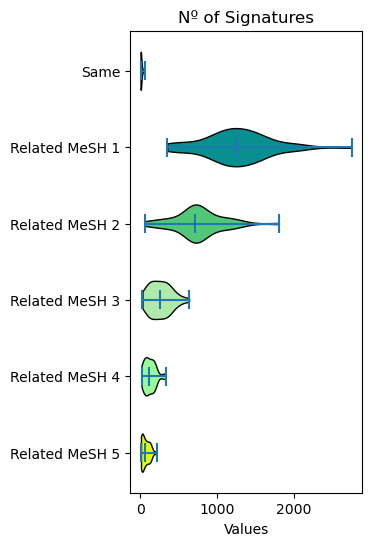

In [98]:
plot_boxplots(data=d_n_signatures)

#### Plots

In [99]:
# functions
def plot_metrics(
    values_list,
    ks_values_list,
    labels,
    vector_type,
    metric_list,
    cap_value=None,
    save=True,
    sparsity="HS",
    values_per_disease=True,
):

    # define variables

    colors = {0: "darkgrey", 1: "#088F8F", 2: "#AFEAAA", 3: "#DFFF00"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1.01, 0.05),
        "cosine": np.arange(0, 2.01, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }
    fixed_bins = fixed_bins_dict.get(metric)
    print(metric)
    print(fixed_bins)
    plt.figure(figsize=(4.5, 3))

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        alpha = 0.5
        if i == 0:
            alpha = 1

        # compute normalized density counts for each distribution
        if values_per_disease:
            # compute normalized density counts for each distribution
            counts = create_composite_histogram(values, fixed_bins)
        else:
            counts, _ = np.histogram(values, bins=fixed_bins)
            counts = counts / len(values)

        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2.5,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
    # Formatting each p-value mean and std, and constructing parts of the title

    formatted_parts = [format_p_value_std(mean, std) for mean, std in ks_values_list]

    # Constructing the full title
    title = (
        "Same-MeSH 1 KS p-value: {}\n"
        "Same-MeSH 3 KS p-value: {}\n"
        "Same-MeSH 5 KS p-value: {}"
    ).format(*formatted_parts)

    plt.title(title, fontsize=10)

    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}{filtering}.mesh_levels.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )

In [100]:
def flatten(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]


def format_p_value(p):
    """Format the p-value in scientific notation if very small, else normal floating point notation."""
    return f"{p:.4e}" if p < 0.0001 else f"{p:.4f}"


# functions
def plot_global_metrics(
    values_list,
    labels,
    vector_type,
    metric_list,
    cap_value=None,
    save=True,
    sparsity="HS",
    modify_values=None,
):

    _values_list = list()
    for i, values in enumerate(values_list):
        if i == 0:
            if modify_values == "mean":
                _values_list.append([np.mean(x) for x in values])

            if modify_values == "min":
                _values_list.append([np.min(x) for x in values])

            if modify_values == "max":
                _values_list.append([np.max(x) for x in values])
        else:
            for matrix in values:
                values_disease = list()
                for sample_matrix in np.array_split(matrix[i, :], 100):
                    if modify_values == "mean":
                        values_disease.append(np.mean(sample_matrix))
                    if modify_values == "min":
                        values_disease.append(np.min(sample_matrix))
                    if modify_values == "max":
                        values_disease.append(np.max(sample_matrix))
            _values_list.append(values_disease)
    # re-define values list
    values_list = _values_list

    # define variables
    colors = {0: "#D3D3D3", 1: "#088F8F", 2: "#AFEAAA", 3: "#DFFF00"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1, 0.05),
        "cosine": np.arange(0, 2, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }

    if modify_values is not None:
        ks_p_values_1_mean = ks_2samp(values_list[0], values_list[1])[1]
        ks_p_values_2_mean = ks_2samp(values_list[0], values_list[2])[1]
        ks_p_values_3_mean = ks_2samp(values_list[0], values_list[3])[1]

    ks_values_list = [ks_p_values_1_mean, ks_p_values_2_mean, ks_p_values_3_mean]

    fixed_bins = fixed_bins_dict.get(metric)
    print(metric)
    print(fixed_bins)
    plt.figure(figsize=(4.5, 3))

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        if i == 0:
            alpha = 1
            counts, _ = np.histogram(values, bins=fixed_bins)
        else:
            alpha = 0.5
            print(values)
            # counts = create_composite_histogram(values, fixed_bins, is_list=True)
            counts, _ = np.histogram(values, bins=fixed_bins)
            # counts = counts / 100
        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])
        print(len(counts))

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2.5,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt

    formatted_p_values = [format_p_value(p) for p in ks_values_list]

    # Constructing the title with formatted p-values
    title = (
        "Same-MeSH 1 KS p-value: {}\n"
        "Same-MeSH 3 KS p-value: {}\n"
        "Same-MeSH 5 KS p-value: {}"
    ).format(*formatted_p_values)

    plt.title(
        title,
        fontsize=10,
    )
    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}{filtering}.{modify_values}.mesh_levels.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )

##### Plot Pearson Correlation

p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


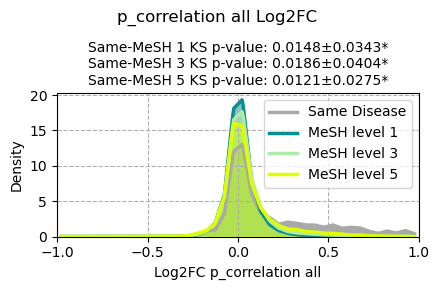

In [101]:
# all


value_i = d_mesh_correlation[1]["interest"]

value_1 = d_mesh_correlation[1]["related"]

value_2 = d_mesh_correlation[3]["related"]

value_3 = d_mesh_correlation[5]["related"]

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "all"],
    save=True,
)

p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


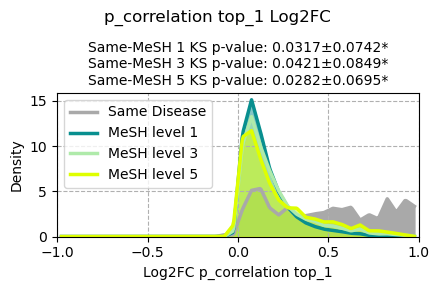

In [102]:
# top k

top_k = 1

value_i = list()
for matrix in d_mesh_correlation[1]["interest"]:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=False)
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_correlation[1]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_correlation[3]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_correlation[5]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_1"],
    save=True,
)

p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


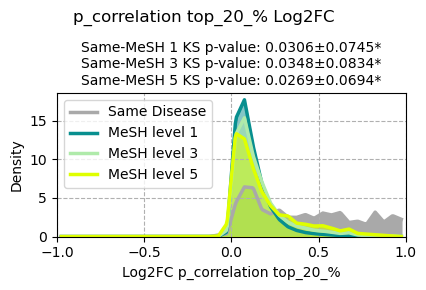

In [103]:
# top k

top_k = 0.2

value_i = list()
for matrix in d_mesh_correlation[1]["interest"]:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True)
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_correlation[1]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_correlation[3]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_correlation[5]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_20_%"],
    save=True,
)

2024-04-26 20:42:21,098 - INFO - Nº of values: 100 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


2024-04-26 20:42:22,478 - INFO - Nº of values: 100 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


2024-04-26 20:42:23,854 - INFO - Nº of values: 100 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


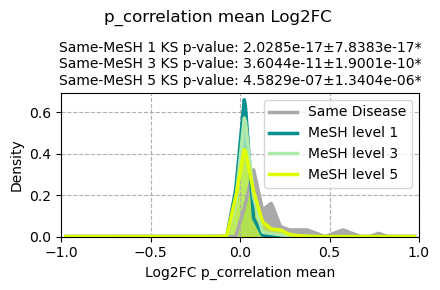

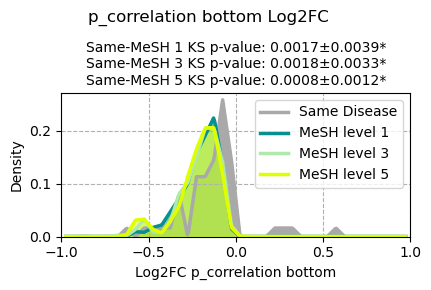

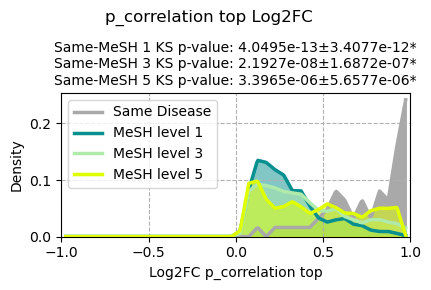

In [104]:
# mean max min
operation_d = {"mean": np.mean, "bottom": np.min, "top": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_i = [
        operation(matrix.flatten()) for matrix in d_mesh_correlation[1]["interest"]
    ]

    value_1 = [[] for _ in range(100)]
    for matrix in d_mesh_correlation[1]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_1[j].append(operation(sample.flatten()))

    value_2 = [[] for _ in range(100)]
    for matrix in d_mesh_correlation[3]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in d_mesh_correlation[5]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_1[i])[1])
    ks_p_values_1_mean, ks_p_values_1_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_2[i])[1])
    ks_p_values_2_mean, ks_p_values_2_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_3[i])[1])
    ks_p_values_3_mean, ks_p_values_3_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [value_i, flatten(value_1), flatten(value_2), flatten(value_3)]

    ks_values_list = [
        [ks_p_values_1_mean, ks_p_values_1_std],
        [ks_p_values_2_mean, ks_p_values_2_std],
        [ks_p_values_3_mean, ks_p_values_3_std],
    ]
    labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["p_correlation", operation_type],
        values_per_disease=False,
        save=True,
    )

##### Euclidean

In [105]:
# define values
step = 25
cap_val = (
    500
    if 500 < np.max(matrix_euclidean_distance)
    else np.max(matrix_euclidean_distance) + 1
)


# Function to cap values at a specific limit
def cap_values_at_limit(values, limit):
    return np.where(values > limit, limit, values)

euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


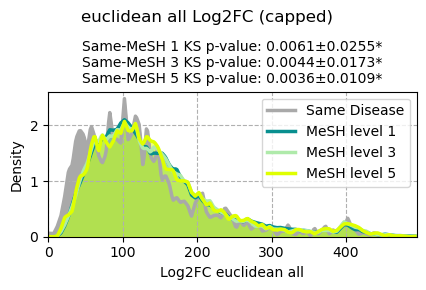

In [ ]:
# all

value_i = d_mesh_euclidean[1]["interest"]
value_1 = d_mesh_euclidean[1]["related"]
value_2 = d_mesh_euclidean[3]["related"]
value_3 = d_mesh_euclidean[5]["related"]

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "all"],
    save=True,
    cap_value=cap_val,
)

In [107]:
# top k

top_k = 1

value_i = list()
for matrix in d_mesh_euclidean[1]["interest"]:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_euclidean[1]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_euclidean[3]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_euclidean[5]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_1"],
    save=True,
    cap_value=cap_val,
)

KeyboardInterrupt: 

euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


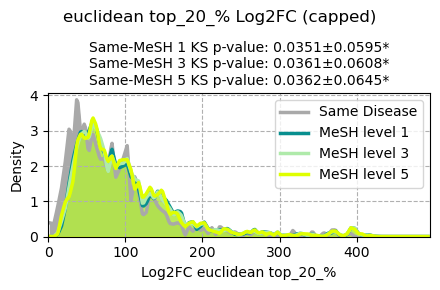

In [ ]:
# top k %

top_k = 0.2

value_i = list()
for matrix in d_mesh_euclidean[1]["interest"]:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_euclidean[1]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_euclidean[3]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_euclidean[5]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_20_%"],
    save=True,
    cap_value=cap_val,
)

2024-04-25 17:28:55,205 - INFO - Nº of values: 100 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


2024-04-25 17:28:56,708 - INFO - Nº of values: 100 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


2024-04-25 17:28:58,241 - INFO - Nº of values: 100 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


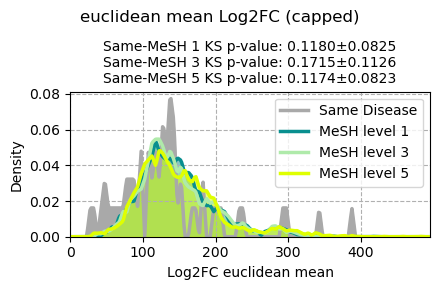

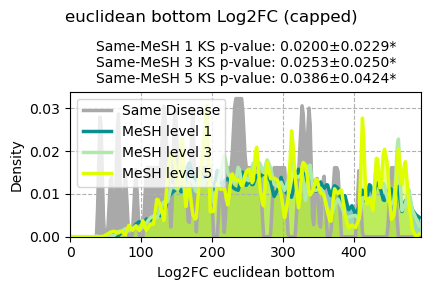

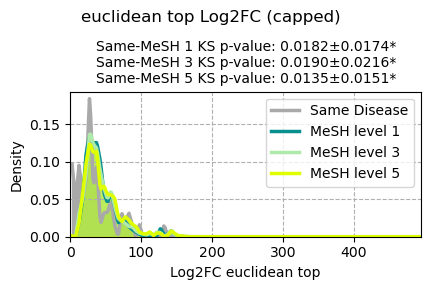

In [ ]:
operation_d = {"mean": np.mean, "top": np.min, "bottom": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_i = [
        operation(matrix.flatten()) for matrix in d_mesh_euclidean[1]["interest"]
    ]

    value_1 = [[] for _ in range(100)]
    for matrix in d_mesh_euclidean[1]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_1[j].append(operation(sample.flatten()))

    value_2 = [[] for _ in range(100)]
    for matrix in d_mesh_euclidean[3]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in d_mesh_euclidean[5]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_1[i])[1])
    ks_p_values_1_mean, ks_p_values_1_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_2[i])[1])
    ks_p_values_2_mean, ks_p_values_2_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_3[i])[1])
    ks_p_values_3_mean, ks_p_values_3_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [value_i, flatten(value_1), flatten(value_2), flatten(value_3)]

    ks_values_list = [
        [ks_p_values_1_mean, ks_p_values_1_std],
        [ks_p_values_2_mean, ks_p_values_2_std],
        [ks_p_values_3_mean, ks_p_values_3_std],
    ]
    labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["euclidean", operation_type],
        values_per_disease=False,
        cap_value=cap_val,
        save=True,
    )

##### Cosine

cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


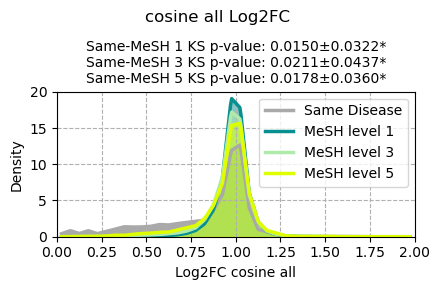

In [ ]:
# all

value_i = d_mesh_cosine[1]["interest"]
value_1 = d_mesh_cosine[1]["related"]
value_2 = d_mesh_cosine[3]["related"]
value_3 = d_mesh_cosine[5]["related"]

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "all"],
    save=True,
)

cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


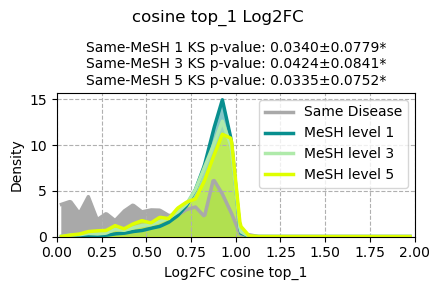

In [ ]:
# top k

top_k = 1

value_i = list()
for matrix in d_mesh_cosine[1]["interest"]:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_cosine[1]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_cosine[3]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_cosine[5]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_1"],
    save=True,
)

cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


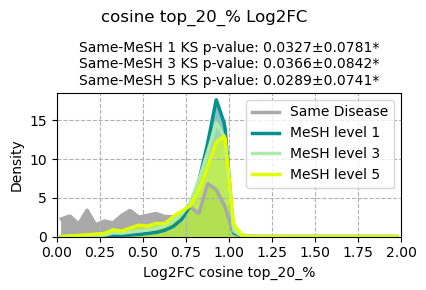

In [ ]:
# top k %

top_k = 0.2

value_i = list()
for matrix in d_mesh_cosine[1]["interest"]:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_cosine[1]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_cosine[3]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_cosine[5]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_20_%"],
    save=True,
)

2024-04-25 17:30:01,557 - INFO - Nº of values: 100 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


2024-04-25 17:30:03,000 - INFO - Nº of values: 100 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


2024-04-25 17:30:04,369 - INFO - Nº of values: 100 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


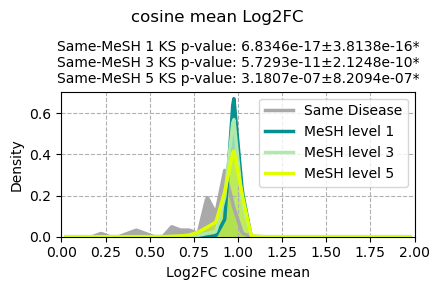

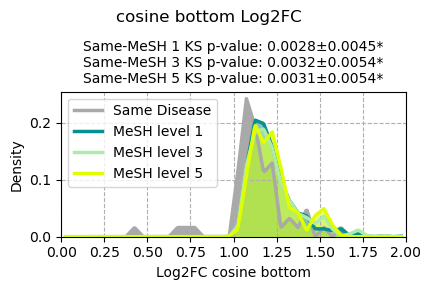

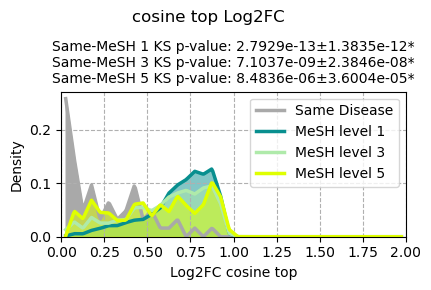

In [ ]:
operation_d = {"mean": np.mean, "top": np.min, "bottom": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_i = [operation(matrix.flatten()) for matrix in d_mesh_cosine[1]["interest"]]

    value_1 = [[] for _ in range(100)]
    for matrix in d_mesh_cosine[1]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_1[j].append(operation(sample.flatten()))

    value_2 = [[] for _ in range(100)]
    for matrix in d_mesh_cosine[3]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in d_mesh_cosine[5]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_1[i])[1])
    ks_p_values_1_mean, ks_p_values_1_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_2[i])[1])
    ks_p_values_2_mean, ks_p_values_2_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_3[i])[1])
    ks_p_values_3_mean, ks_p_values_3_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [value_i, flatten(value_1), flatten(value_2), flatten(value_3)]

    ks_values_list = [
        [ks_p_values_1_mean, ks_p_values_1_std],
        [ks_p_values_2_mean, ks_p_values_2_std],
        [ks_p_values_3_mean, ks_p_values_3_std],
    ]
    labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["cosine", operation_type],
        values_per_disease=False,
        save=True,
    )

### NN

In [ ]:
def get_k_precision(idxs, k, matrix):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs: list of indexes
        k: int
        matrix: np.array
    Returns:
        np.array
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    return np.sum(labels[idx_k], axis=1) / 3

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    average_precision_score,
)
import numpy as np


def get_k_precision(idxs, k, matrix):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs: list of indexes
        k: int
        matrix: np.array
    Returns:
        np.array
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    return np.sum(labels[idx_k], axis=1) / 3


def get_k_precision(idxs, k, matrix, top=True):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs (list): indexes
        k (int): k values
        matrix (np.array): matrix of similarities
        top (bool): get top k or bottom k
    Returns:
        np.array: precision values
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    if top:
        idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    else:
        idx_k = np.argpartition(matrix[idxs], k, axis=1)[:, :k]
    return list(np.sum(labels[idx_k], axis=1))


# Example AUROC calculation using kNN for each disease signature
auroc_scores = {"correlation": [], "cosine": [], "euclidean": [], "disease": []}
auroc_scores = {"correlation": [], "disease": []}

# Assuming `data_matrix` is your feature matrix where rows are disease signatures
num_diseases = len(most_common_diseases)

copy_matrix_pearson_correlation = np.copy(matrix_pearson_correlation)
np.fill_diagonal(copy_matrix_pearson_correlation, 0)

copy_matrix_cosine_distance = np.copy(matrix_cosine_distance)
np.fill_diagonal(copy_matrix_cosine_distance, 1)

copy_matrix_euclidean_distance = np.copy(matrix_euclidean_distance)
np.fill_diagonal(copy_matrix_euclidean_distance, np.inf)


correlation_tp = list()
cosine_tp = list()
euclidean_tp = list()

for idx, disease in tqdm(enumerate(most_common_diseases)):

    # dsaids w/ diseases of interest
    QUERY = f"disease == @disease"
    df_query = df_matrix.query(QUERY)
    dsaids_interest = df_query["dsaid"].to_list()
    interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

    correlation_tp.append(
        get_k_precision(interest_idxs, 3, copy_matrix_pearson_correlation)
    )

    cosine_tp.append(
        get_k_precision(interest_idxs, 3, copy_matrix_cosine_distance, top=False)
    )
    euclidean_tp.append(
        get_k_precision(interest_idxs, 3, copy_matrix_euclidean_distance, top=False)
    )

del (
    copy_matrix_pearson_correlation,
    copy_matrix_cosine_distance,
    copy_matrix_euclidean_distance,
)

209it [00:00, 291.46it/s]


<Axes: >

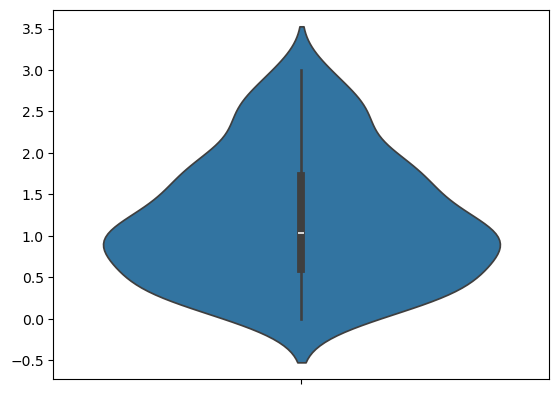

In [ ]:
sns.violinplot([np.mean(x) for x in correlation_tp])

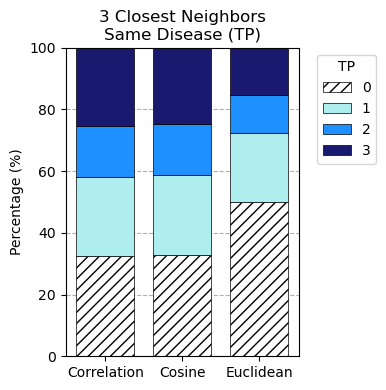

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data for each metric (assuming integers 0, 1, 2, 3 represent the count of nearest neighbors that are the same disease)
data_1 = flatten(correlation_tp)  # Correlation
data_2 = flatten(cosine_tp)  # Cosine
data_3 = flatten(euclidean_tp)  # Euclidean

# Bin edges for the categories
bins = np.array([0, 1, 2, 3, 4])

# define colors
colors = ["white", "paleturquoise", "#1E90FF", "midnightblue"]

# Calculate histogram data for each
counts_1, _ = np.histogram(data_1, bins=bins)
counts_2, _ = np.histogram(data_2, bins=bins)
counts_3, _ = np.histogram(data_3, bins=bins)

# Labels for the plot
metrics_labels = ["Correlation", "Cosine", "Euclidean"]
category_labels = [f"{i}" for i in range(4)]  # Labels for the legend

# Create the figure and axes
fig, ax = plt.subplots(figsize=(4, 4))

# Width of each stack segment
width = 0.75

# Convert counts to percentage
percentage_1 = counts_1 / len(data_1) * 100
percentage_2 = counts_2 / len(data_2) * 100
percentage_3 = counts_3 / len(data_3) * 100

# Stack the bars for each metric
for i, counts in enumerate([percentage_1, percentage_2, percentage_3]):
    bottom_shift = np.cumsum([0] + counts.tolist())[
        :-1
    ]  # Calculate the bottom position for each stack
    for j in range(len(counts)):

        if j == 0:
            ax.bar(
                metrics_labels[i],
                counts[j],
                bottom=bottom_shift[j],
                width=width,
                label=f"{category_labels[j]}" if i == 0 else "",
                color=colors[j],
                zorder=2,
                edgecolor="black",
                linewidth=0.5,
                hatch="///",
            )
        else:
            ax.bar(
                metrics_labels[i],
                counts[j],
                bottom=bottom_shift[j],
                width=width,
                label=f"{category_labels[j]}" if i == 0 else "",
                color=colors[j],
                zorder=2,
                edgecolor="black",
                linewidth=0.5,
            )

# Add a legend and axis labels
ax.set_ylabel("Percentage (%)")
ax.set_title("3 Closest Neighbors\nSame Disease (TP)")
ax.legend(title="TP", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.ylim(0, 100)
# Show the plot
plt.grid(linestyle="--", zorder=-3)
plt.tight_layout()

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"nn.{metric_evaluated}.mesh.{sparsity}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

## Testing Area